<div style="text-align: center;">
  <img src="https://github.com/Hack-io-Data/Imagenes/blob/main/01-LogosHackio/logo_naranja@4x.png?raw=true" alt="esquema" />
</div>


# Laboratorio de Gestión de Outliers

AutoRenew, la empresa líder en la venta de coches de segunda mano, sigue adelante con el desarrollo del modelo predictivo que ayudará a estimar el precio de los vehículos usados. Este modelo es clave para mejorar las estrategias de ventas, marketing y optimización del inventario de la empresa. Ya has realizado un análisis exploratorio inicial y gestionado los valores nulos en el conjunto de datos. Ahora, es el momento de abordar otro aspecto crucial del preprocesamiento: la **gestión de outliers**.

En este laboratorio, te enfocarás en identificar y gestionar los outliers (valores atípicos) presentes en el conjunto de datos. Los outliers pueden distorsionar los resultados de un análisis y afectar negativamente el rendimiento de los modelos predictivos, por lo que es fundamental tratarlos adecuadamente antes de proceder con las siguientes fases del proyecto.


**Instrucciones:**

1. **Identificación de Outliers:** Explora las columnas clave del conjunto de datos (como `price`, `powerCV`, `kilometer`, etc.) para identificar posibles outliers. Utiliza gráficos como diagramas de caja (boxplots) y análisis estadísticos para detectar valores que se desvíen significativamente del resto de los datos.

2. **Análisis de Outliers:** Una vez identificados, analiza los outliers para determinar si son errores de datos, valores extremos válidos o resultados de condiciones específicas que deben ser tenidos en cuenta. Considera el contexto de cada columna al evaluar la relevancia de estos valores atípicos.

3. **Gestión de Outliers:** Decide la estrategia más adecuada para manejar los outliers. Esto podría incluir la eliminación de los outliers, la transformación de los datos, o la aplicación de técnicas de imputación. Justifica tu elección basándote en cómo los outliers podrían afectar el modelo predictivo.

**Nota:** Recuerda que este laboratorio es parte de una serie de actividades en las que utilizarás el mismo conjunto de datos a lo largo de la semana. Documenta cuidadosamente los pasos que sigas para que puedas referirte a ellos en las próximas etapas del proyecto.


### 0. Imports

In [34]:
# Tratamiento de datos
# -----------------------------------------------------------------------
import numpy as np
import pandas as pd

# Otros objetivos
# -----------------------------------------------------------------------
import math

# Gráficos
# -----------------------------------------------------------------------
import seaborn as sns
import matplotlib.pyplot as plt
import plotly_express as px


# Métodos estadísticos
# -----------------------------------------------------------------------
from scipy.stats import zscore # para calcular el z-score
from sklearn.neighbors import LocalOutlierFactor # para detectar outliers usando el método LOF
from sklearn.ensemble import IsolationForest # para detectar outliers usando el metodo IF
from sklearn.neighbors import NearestNeighbors # para calcular la epsilon

# Para generar combinaciones de listas
# -----------------------------------------------------------------------
from itertools import product, combinations

# Gestionar warnings
# -----------------------------------------------------------------------
import warnings
warnings.filterwarnings('ignore')

# Gestionar variables del path
# -----------------------------------------------------------------------
import sys
sys.path.append("..")

# Importar scripts de soporte
# -----------------------------------------------------------------------
import src.soporte_outliers as so

# Encoding categoricos
# -----------------------------------------------------------------------
import category_encoders as ce

### 1. Importar datos

En este caso se considera más intuitivo realizar el análisis y gestión de outliers desde el punto en el que se culminó la gestión de nulos, ya que con las variables escaladas es más difícil entender los contextos que con las variables no escaladas.

In [2]:
autorenew_df = pd.read_csv("../datos/autorenew_sinnulos.csv", index_col=0)
autorenew_df.drop(columns="index",inplace=True)
autorenew_df.head()

,datecrawled,price,abtest,vehicletype,yearofregistration,gearbox,powercv,model,kilometer,monthofregistration,fueltype,brand,notrepaireddamage,datecreated,postalcode,lastseen,fueltype_grouped,brand_grouped
0,2016-03-24 11:52:17,480.0,test,coupe,1993.0,manually,89.0,golf,150000.0,0.0,petrol,volkswagen,no,2016-03-24,70435,2016-04-07 03:16:57,petrol,volkswagen
1,2016-03-24 10:58:45,18300.0,test,coupe,2011.0,manually,187.0,c2,125000.0,5.0,diesel,audi,yes,2016-03-24,66954,2016-04-07 01:46:50,diesel,audi
2,2016-03-14 12:52:21,9800.0,test,suv,2004.0,automatic,161.0,grand,125000.0,8.0,diesel,jeep,no,2016-03-14,90480,2016-04-05 12:47:46,diesel,other
3,2016-03-17 16:54:04,1500.0,test,small car,2001.0,manually,74.0,golf,150000.0,6.0,petrol,volkswagen,no,2016-03-17,91074,2016-03-17 17:40:17,petrol,volkswagen
4,2016-03-31 17:25:20,3600.0,test,small car,2008.0,manually,68.0,fabia,90000.0,7.0,diesel,skoda,no,2016-03-31,60437,2016-04-06 10:17:21,diesel,skoda


### 2. Identificación de outliers univariados

Hacemos uso de la propia de la documentación de clase para instanciar un objeto de `GestionOutliersUnivariados()` que facilita la gestión de outliers univariados.

In [3]:
gestor_outliers_uni = so.GestionOutliersUnivariados(autorenew_df)

Con el gestor instanciado, podemos hacer uso de sus métodos para, por ejemplo, visualizar los posibles outliers de las columnas numéricas:

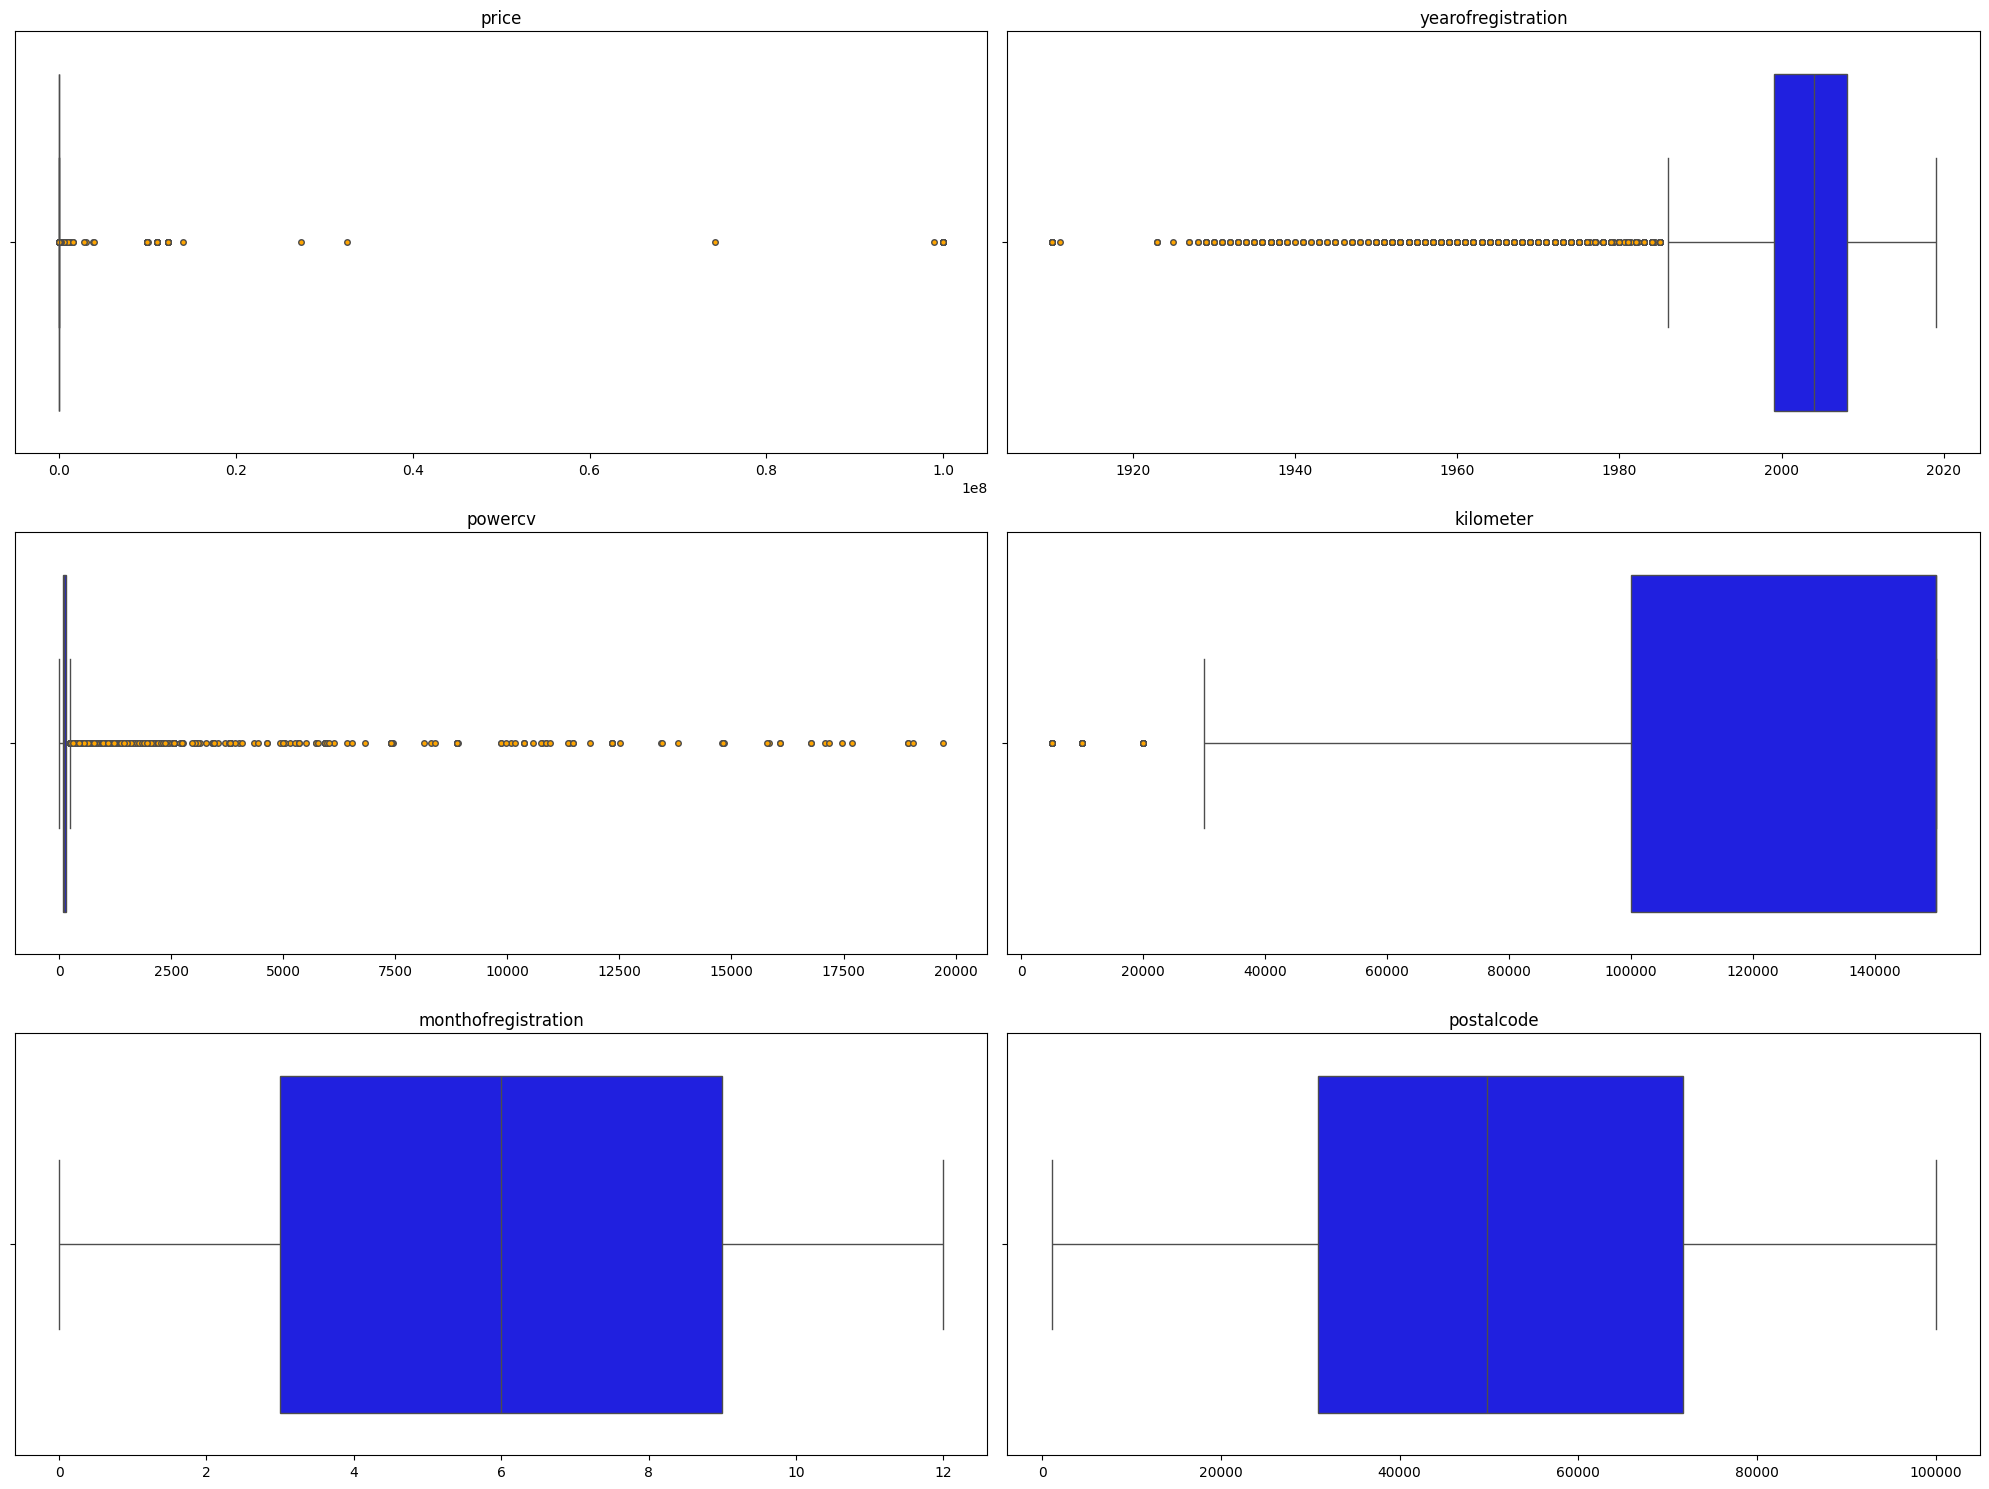

In [4]:
gestor_outliers_uni.visualizar_outliers_univariados()

A partir de los boxplots anteriores se percibe que existe gran cantidad de outliers en las columnas price, powercv, yearofregistration y kilometer. 

Empezando por price, si bien pueden existir coches con un precio de lujo aunque sean de segunda mano, alcanzando varios millones de euros, sería complicado que alcanzaran los 100 millones, como es el caso del valor más extremo de esta variable. Existen outliers individuales o incluso conglomerados en pequeños grupos, que tienen un último hueco alrededor de algo menos de 10 millón de euros, con lo que es posible que sea alrededor de esa zona que los outliers pertenezcan realmente a la distribución.

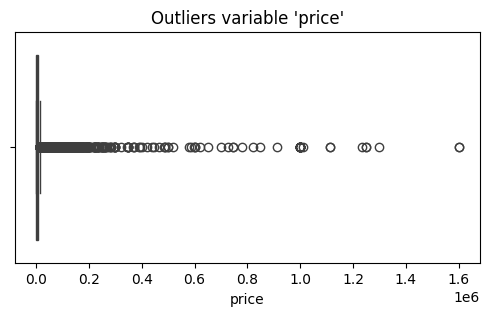

In [5]:
price_10_millones = autorenew_df[autorenew_df["price"]< 2000000]

plt.figure(figsize=(6,3))
plt.title("Outliers variable 'price'")
sns.boxplot(data=price_10_millones, x="price")
plt.show()

In [6]:
autorenew_df.describe()

,price,yearofregistration,powercv,kilometer,monthofregistration,postalcode
count,3.607450e+05,360745.000000,360745.000000,360745.000000,360745.000000,360745.000000
mean,1.185917e+04,2003.443885,127.080728,125661.755534,5.795332,50996.190525
std,6.888829e+05,7.630822,190.813144,39836.468180,3.684674,25760.392690
min,1.000000e+00,1910.000000,1.000000,5000.000000,0.000000,1067.000000
25%,1.250000e+03,1999.000000,79.000000,100000.000000,3.000000,30823.000000
50%,3.000000e+03,2004.000000,111.000000,150000.000000,6.000000,49751.000000
75%,7.490000e+03,2008.000000,148.000000,150000.000000,9.000000,71672.000000
max,1.000000e+08,2019.000000,19726.000000,150000.000000,12.000000,99998.000000


Reduciendo la variable a 10 millones, básicamente haciendo zoom sobre esos valores, aún se encuentran "clusters" de outliers que empiezan a agruparse más dentro de los 2 millones de euros, que empiezan a ser precios más razonables para coches de lujo. Aún así, viendo el percentil 75 parece bastante probable que AutoRenew venda mayoritariamente coches asequibles.

Dado que el boxplot automáticamente detecta los outliers que sobrepasan el Q1 o Q3 por 1,5 veces el IQR, taggearlos para analizarlos visualmente a partir de una tabla no tiene mucho valor, ya que habrá un número extremadamente alto de outliers. Así que habrá que utilizar métodos multivariados para llegar a conclusiones más robustas.

Siguiendo por 'yearofregistration', es posible que en AutoRenew se ofrezcan coches super clásicos, pero es poco probable que venda coches anteriores a 1920, así que estos valores podrían convertirse a nulos directamente para imputarlos más tarde. Sin embargo, será interesante estudiar si estos valores son detectados como outliers mediante métodos multivariados como el IsolationForest o el LOF.

Lo mismo ocurre con powercv, ya que se conoce que los máximos caballos de potencia de un vehículo son unos 1800 CV aproximadamente. Sin embargo, este conocimiento será interesante contrastarlo con los métodos numéricos de detección de anomalías multivariadas. 

Por último, parece que existen unos pocos coches con menos de 20.000 km, lo cual es bastante razonable dado que existen coches de segunda mano seminuevos o km0. Sin embargo, se mantienen así para estudiar el diagnóstico de los métodos multivariados.

# 3. Identificar outliers bivariados

In [7]:
gestor_outliers_multi = so.GestionOutliersMultivariados(autorenew_df)

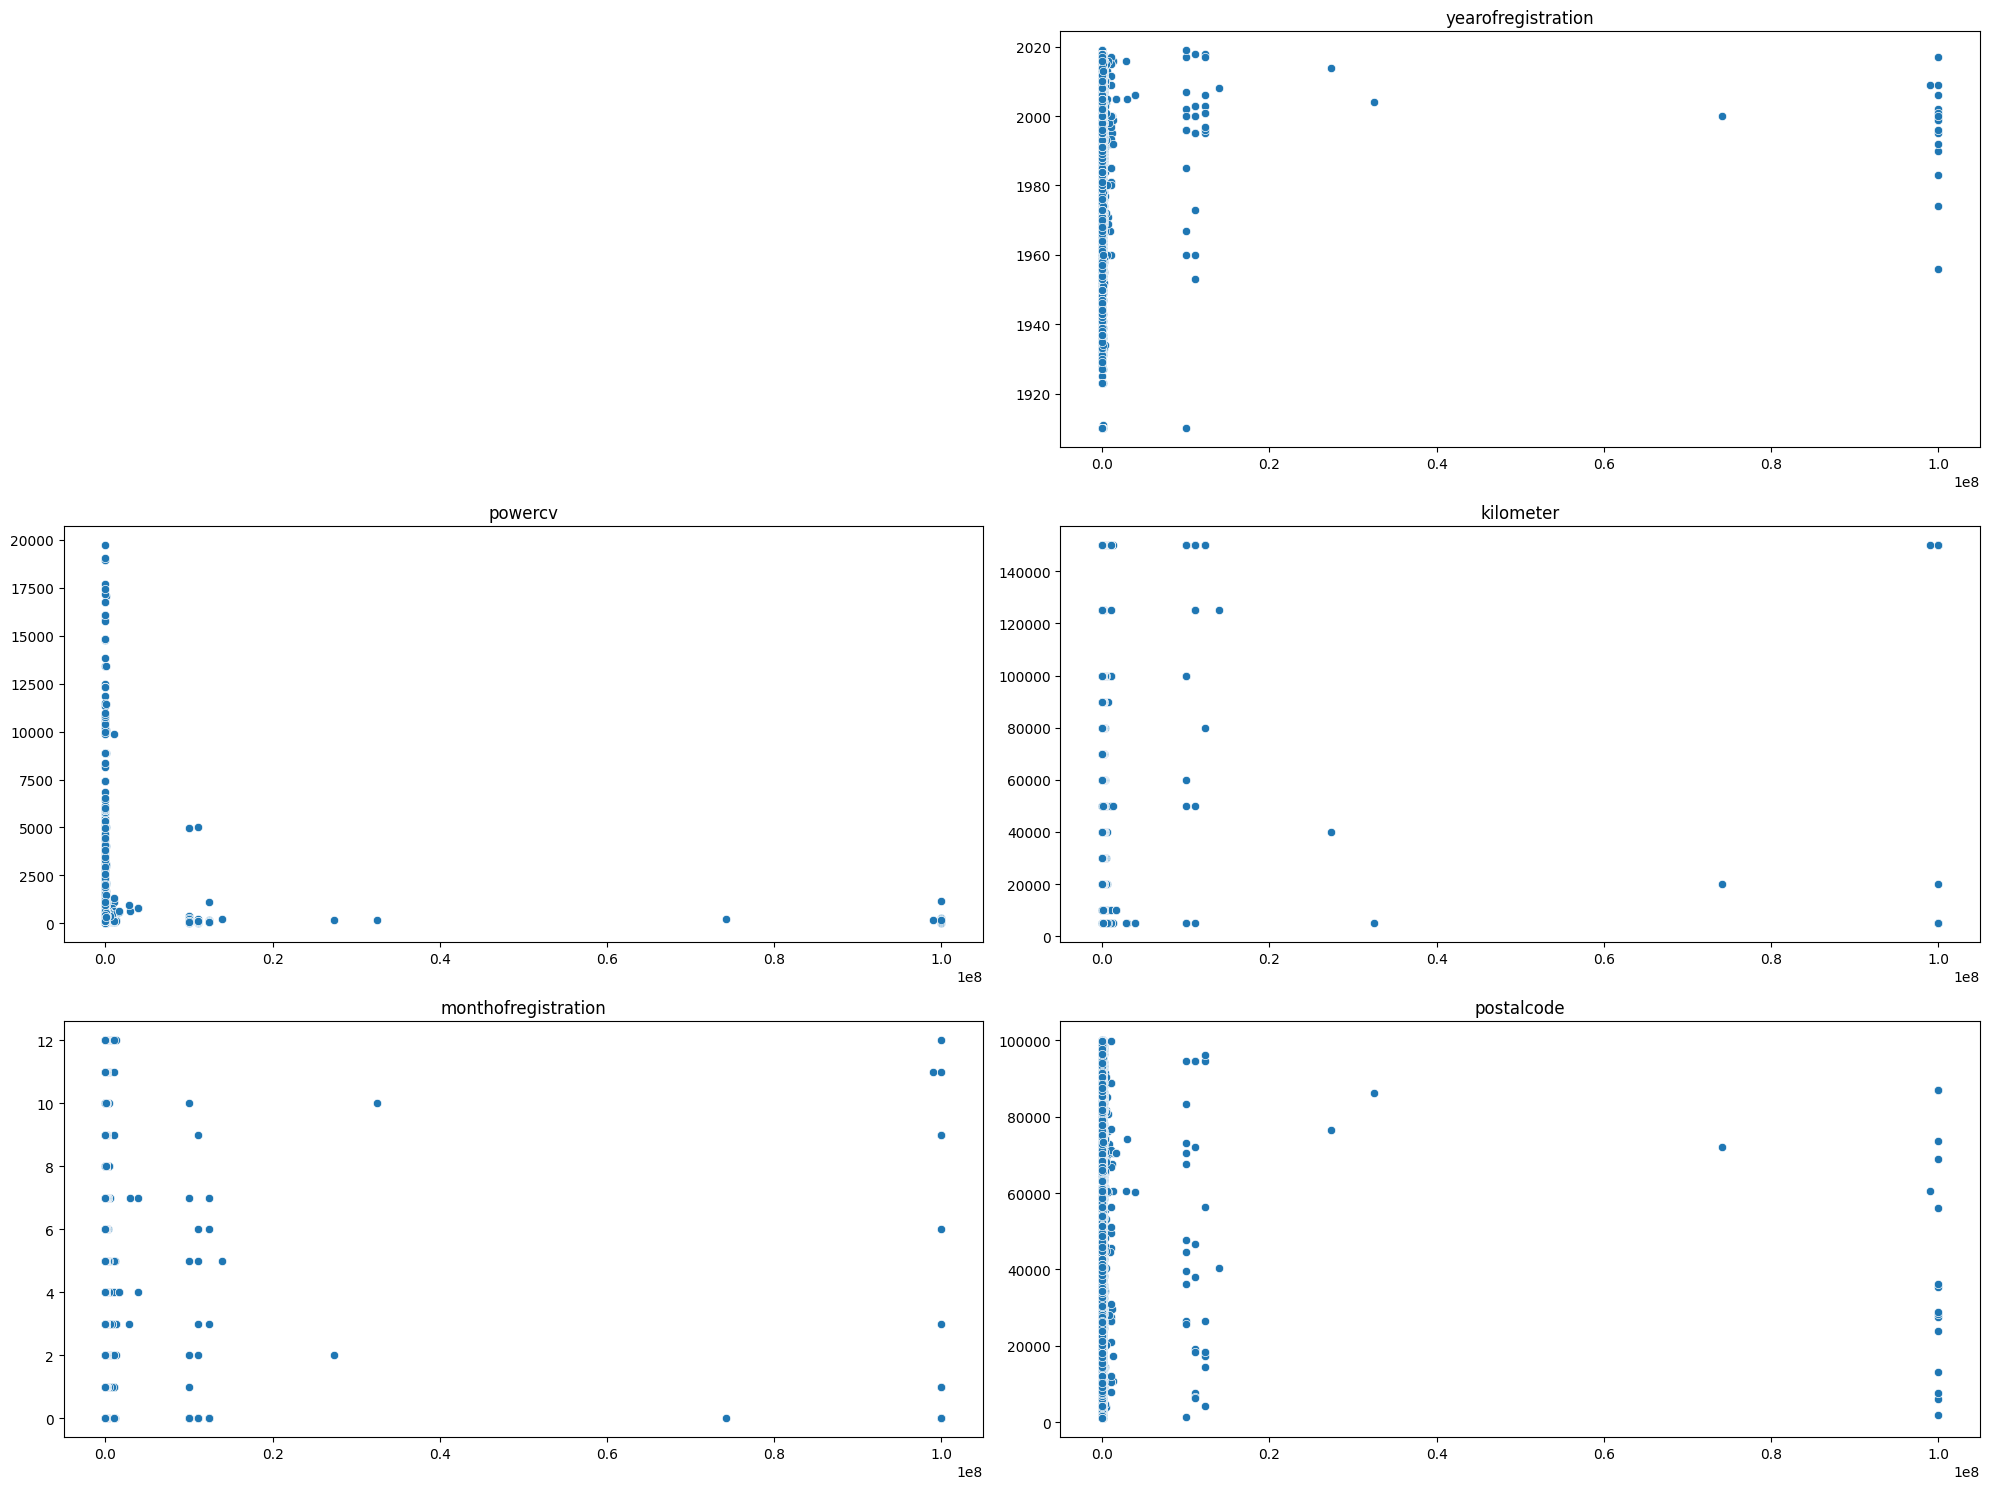

In [8]:
gestor_outliers_multi.visualizar_outliers_bivariados(vr="price")

Comenzando el análisis del scatterplot bivariado por yearofregistration, se aprecia que las observaciones de años de registro muy bajos tienen en su mayoría un coste muy bajo. Eso apunta a que estos valores son erroneos o verdaderamente outliers indeseados, ya que no es lógico que coches clásicos sean baratos a no ser que fueran verdaderas chatarras, con lo que no tendría sentido venderlos.

Mientras que la antigüedad de un coche no tiene siempre una correlación clara con su precio ya que depende de su categoría (de lujo, clásico, etc), la potencia de los coches suele tener una correlación positiva con su precio. En este scatterplot se aprecia claramente que las altas potencias de los coches no van acompañadas de un aumento en el precio y eso no encaja en la lógica del mercado, por lo que seguramente no sean correctos.

Finalmente, los coches con precios extremadamente altos teniendo más de 140.000 km no parecen lógicos tampoco.

Sigue siendo dificil de imaginar ver vehículos de 100 millones de euros, o de más de 1800 CV, pero como se ha comentado se va a continuar sin tratarlos para observar el efecto de las técnicas de gestión multivariante.

Previo al uso de los métodos multivariantes, es interesante observar visualmente los registros que tienen valores descaradamente fuera del espectro aceptable, como los coches de antes de 1920 y de mas de 10 millones.

In [9]:
autorenew_df[(autorenew_df["price"] > 10000000) | (autorenew_df["yearofregistration"] < 1920)].head()

,datecrawled,price,abtest,vehicletype,yearofregistration,gearbox,powercv,model,kilometer,monthofregistration,fueltype,brand,notrepaireddamage,datecreated,postalcode,lastseen,fueltype_grouped,brand_grouped
14,2016-03-11 21:39:15,450.0,test,small car,1910.0,automatic,134.9,ka,5000.0,0.0,petrol,ford,no,2016-03-11,24148,2016-03-19 08:46:47,petrol,ford
7106,2016-03-24 08:37:22,135.0,control,convertible,1910.0,automatic,100.3,fortwo,5000.0,0.0,hybrid,opel,no,2016-03-24,19374,2016-04-06 20:46:08,other,opel
10393,2016-03-27 13:59:08,1250.0,test,convertible,1910.0,automatic,148.5,andere,5000.0,0.0,hybrid,audi,no,2016-03-27,18445,2016-04-07 10:45:31,other,audi
14229,2016-04-03 06:03:56,11111111.0,control,coupe,2003.0,manually,63.0,polo,150000.0,2.0,petrol,volkswagen,no,2016-04-03,46535,2016-04-07 10:16:51,petrol,volkswagen
17707,2016-03-15 21:49:33,99999.0,control,convertible,1910.0,automatic,5015.6,matiz,150000.0,0.0,hybrid,volkswagen,no,2016-03-15,78224,2016-04-07 06:16:06,other,volkswagen


Se encuentran, por ejemplo coches híbridos o automáticos de 1910, o volkwagen de 11 millones de euros. Estos valores no son atípicos que pertenecen a la distribución, sino claramente erróneos. 

Visto lo anterior, se puede proceder ahora a la exploración y gestión de outliers con métodos multivariantes para comprobar si su detección corresponde con el análisis visual mediante métodos univariados y bivariados, eliminando antes monthofregistration y postalcode.

In [10]:
autorenew_df.drop(columns=["postalcode","monthofregistration"], inplace=True)

# 4. Outliers multivariados

Nuevamente, se define un objeto de gestión de outliers perteneciente al material de soporte, de la clase ``GestionOutliersMultivariados``.

In [11]:
gestor_outliers_multi = so.GestionOutliersMultivariados(autorenew_df[["yearofregistration","powercv","price","kilometer"]])

### 4.1 Método LOF

Se procede a utilizar el método Local Outlier Factor para la detección de outliers multivariados, introduciéndo como input las 4 columnas numéricas del estudio.

En iteraciones anteriores de este mismo notebook se realizó una inspección visual de los outliers mediante el método LOF. Ocurría un problema, y es que los scatterplots generados por la función superponían los puntos considerados outliers y los que no son considerados outliers. Así que, en esta iteración se parte de una aproximación más númerica, que será luego apoyada igualmente por gráficos.

In [108]:
n_neighbours = [300,600]
contaminacion = [0.01,0.05,0.1]
combinaciones = list(product(n_neighbours,contaminacion))

df_lof_total = pd.DataFrame()
for n_neighbours, contaminacion in combinaciones:
    df_lof = gestor_outliers_multi.detectar_outliers_lof(n_neighbours,contaminacion)
    df_lof = df_lof[["outlier"]]
    df_lof.rename(columns={"outlier":f"outliers_lof_{n_neighbours}_{contaminacion}"},inplace=True)
    df_lof_total = pd.concat([df_lof_total,df_lof],axis=1)

df_lof_total.head()

,outliers_lof_300_0.01,outliers_lof_300_0.05,outliers_lof_300_0.1,outliers_lof_600_0.01,outliers_lof_600_0.05,outliers_lof_600_0.1
0,-1,-1,-1,1,-1,-1
1,1,1,1,1,1,1
2,1,1,1,1,1,1
3,1,1,1,1,1,1
4,1,1,1,1,1,1
...,...,...,...,...,...,...
360740,1,1,1,1,1,1
360741,1,1,1,1,1,1
360742,1,1,1,1,1,1
360743,1,1,1,1,1,1


Ahora que se han detectado filas de outliers según la detección del método LOF, es necesario evaluar dicha detección. Dado que se ha trabajado con distintas combinaciones de n_vecinos y pct_contaminación, es interesante combinar los efectos de cada combinacion y evaluar cuales son los outliers encontrados según el número de veces que estos han sido taggeados con dicha etiqueta.

Para ello, se reemplazan los -1 y 1 por 1 y 0 (outlier y no outlier), se crea una columna con los conteos totales de tag 'outlier' y se dibuja su distribución. 

<Axes: xlabel='outlier_count', ylabel='count'>

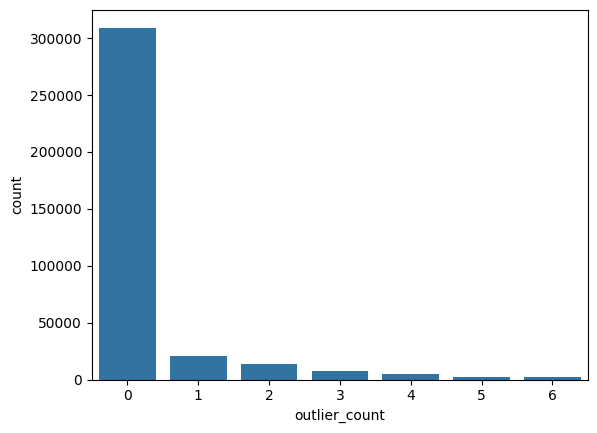

In [109]:
df_lof_total_copy = df_lof_total.copy()
df_lof_total_copy.replace({-1:1,1:0},inplace=True)


autorenew_df["total_outlier"] = np.where(df_lof_total_copy.mean(axis=1) == 1, 1,0).astype("O")
autorenew_df["outlier_count"] = df_lof_total_copy.sum(axis=1)

sns.countplot(data=autorenew_df,x="outlier_count")

Como es lógico, la mayoría de valores son considerados no outliers y dicha frecuencia baja conforme aumenta el número de veces que se considera outlier a la misma observación. Por lo tanto, ahora sí es interesante visualizar los scatterplots bivariados para los outliers considerados como tal en funcion de las veces que reciben dicha etiqueta por las combinaciones de los LOF. De esta forma se pretende discernir si los rangos poco verosímiles de las variables, que anteriormente se sospechaban como  outliers pero se consideró conveniente confirmar mediante métodos multivariados, se corrigen o no.

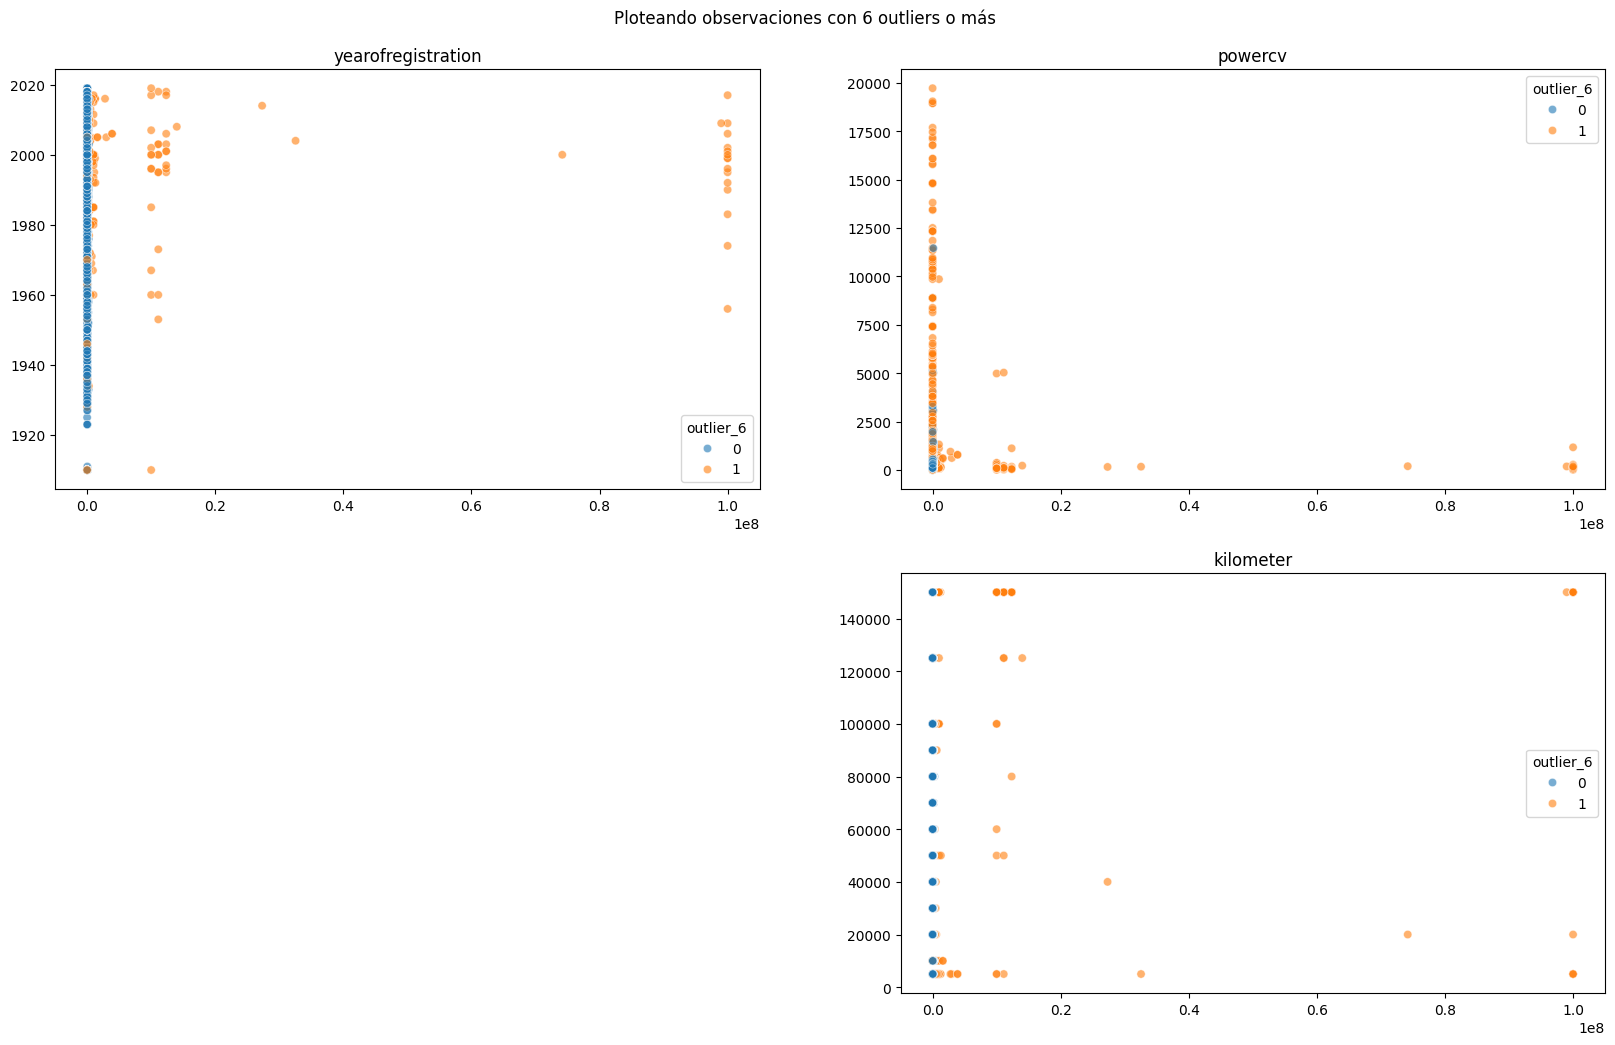

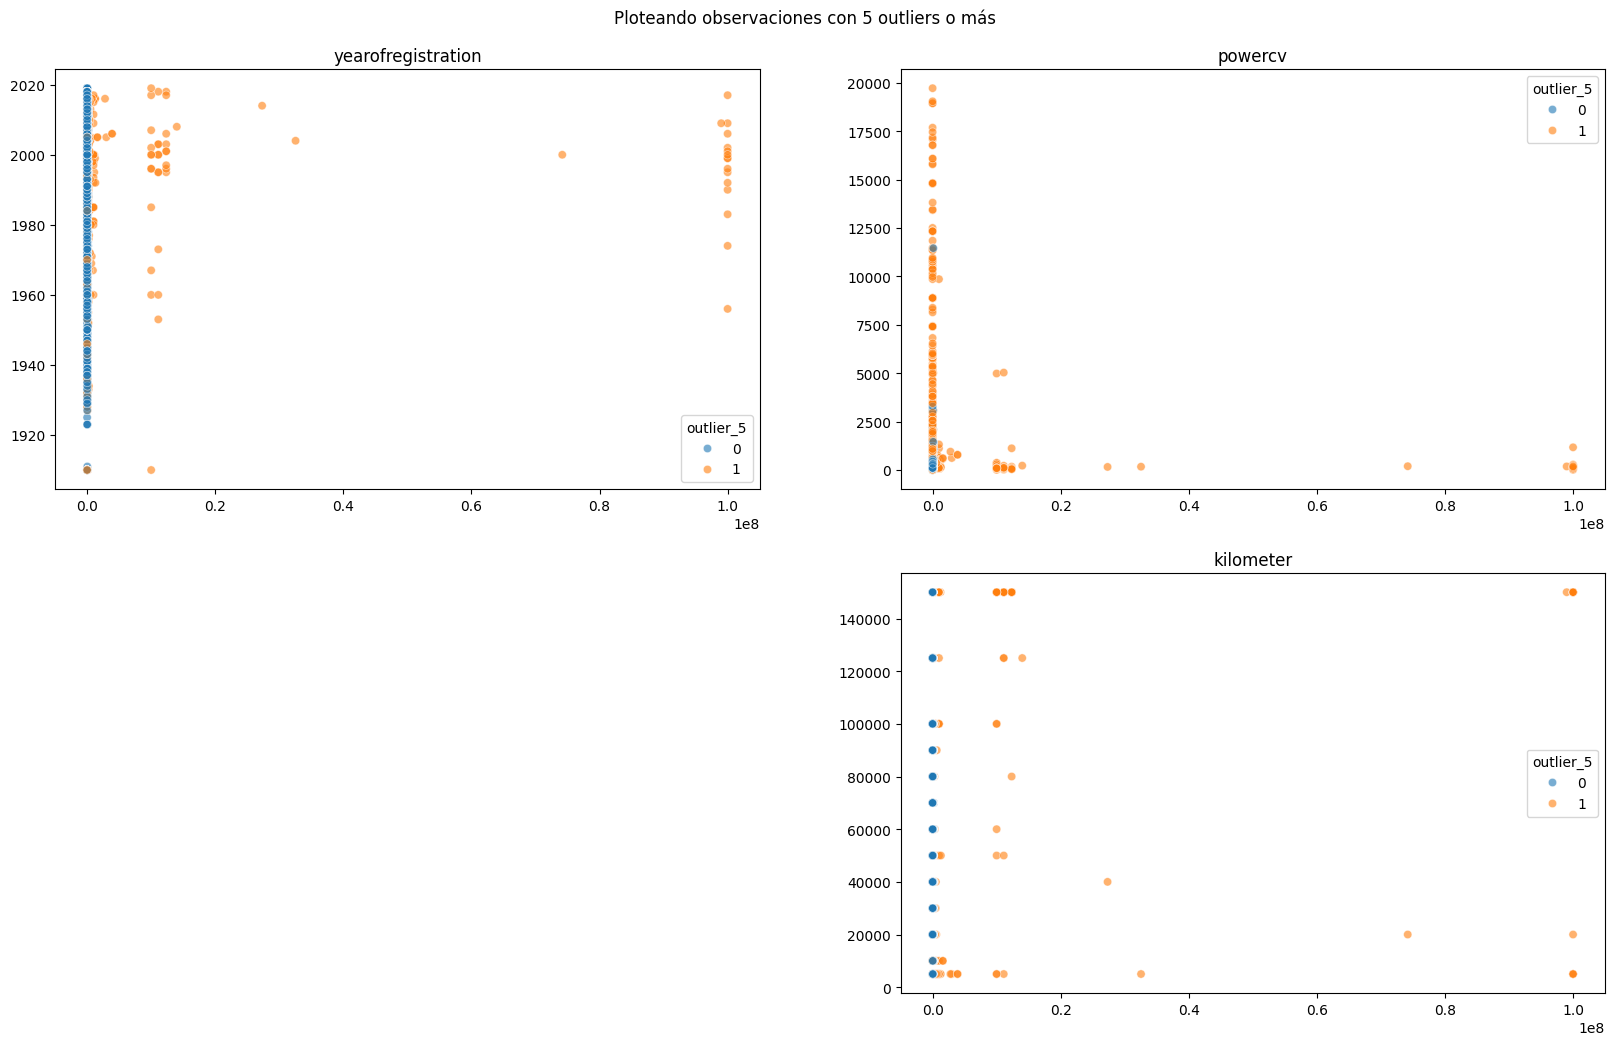

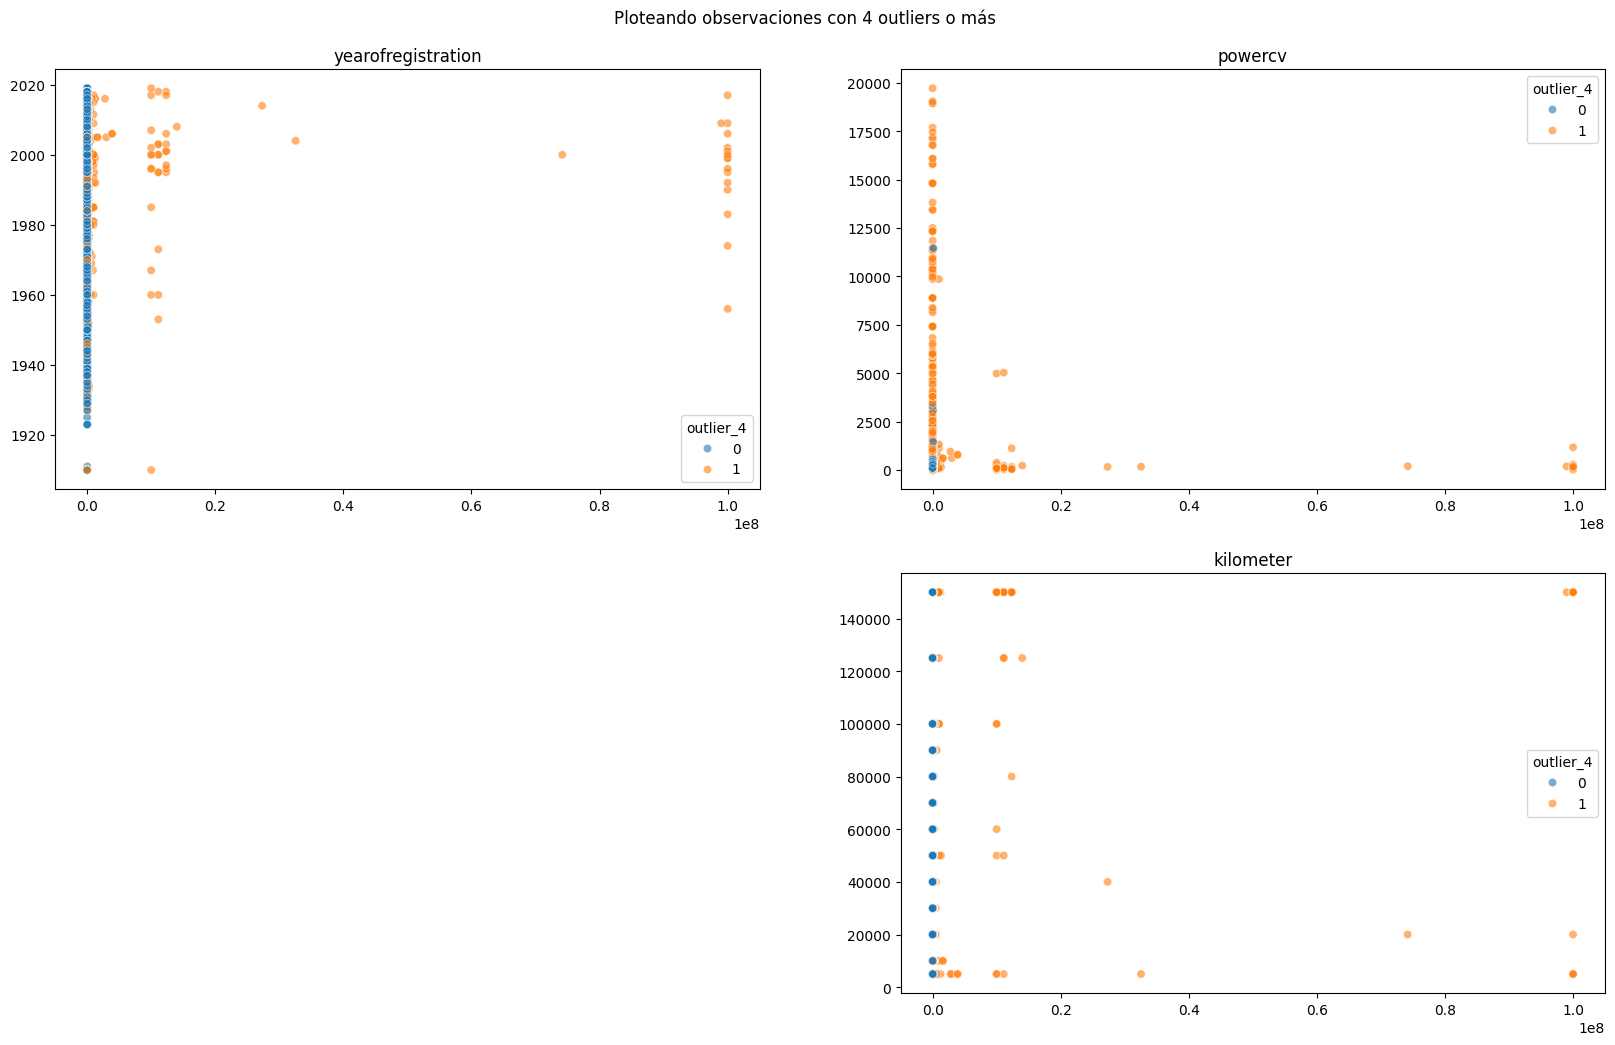

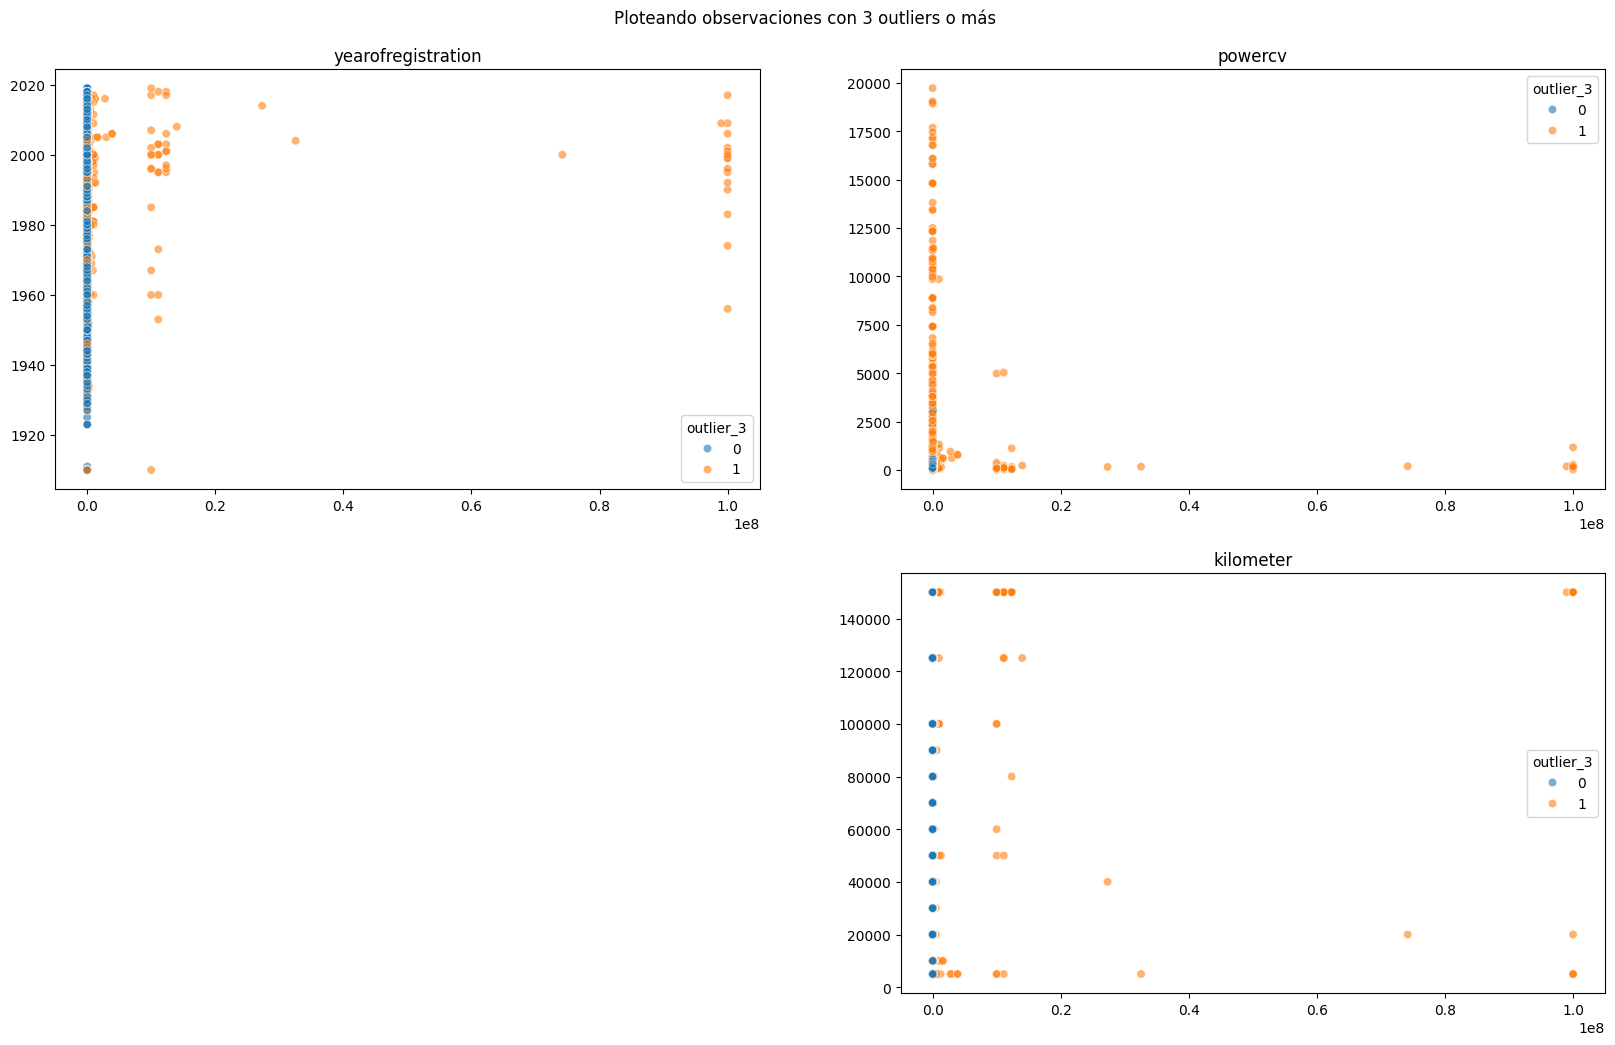

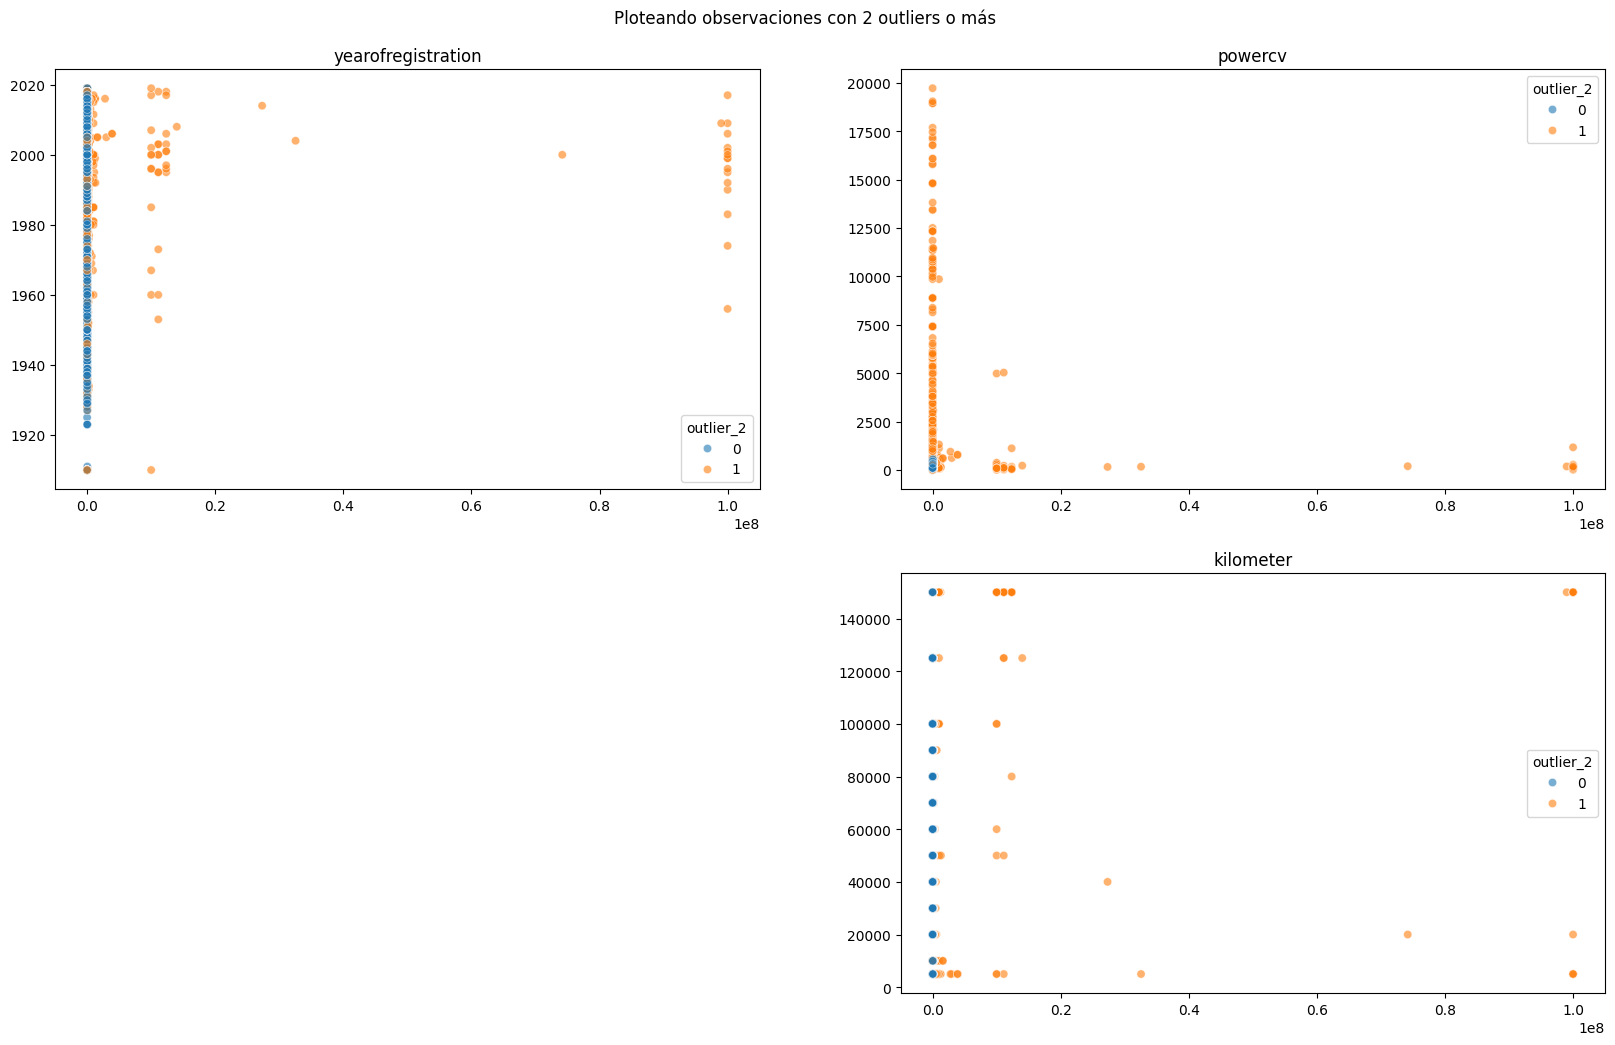

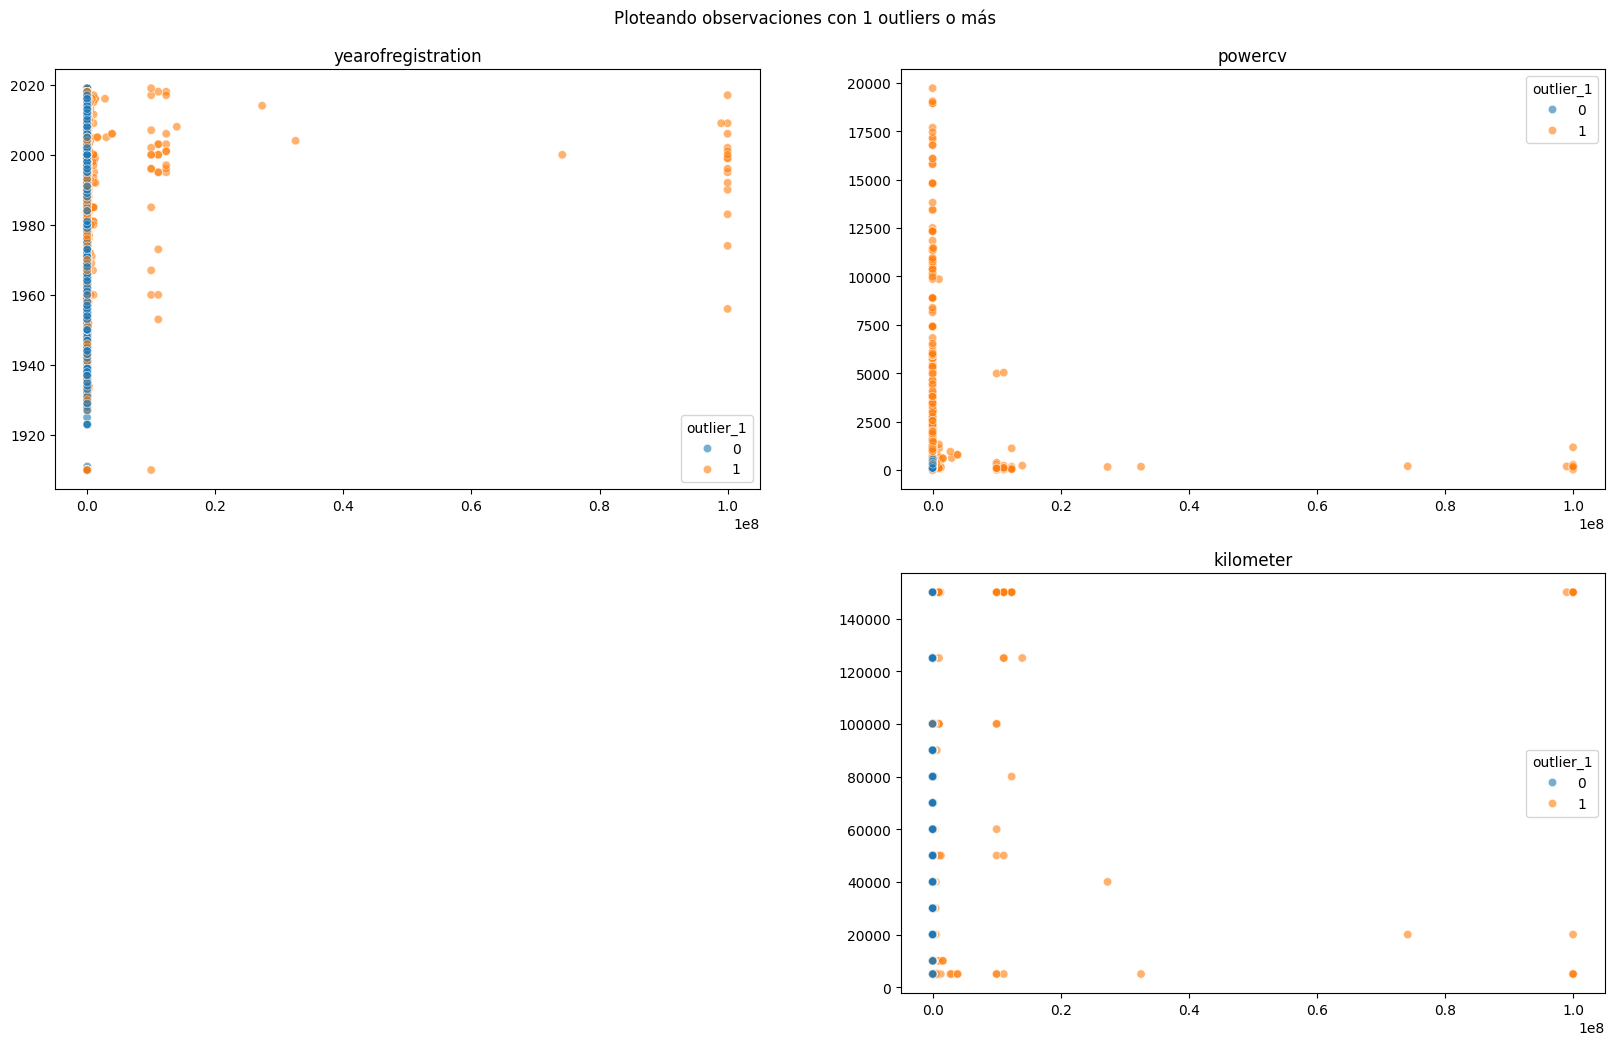

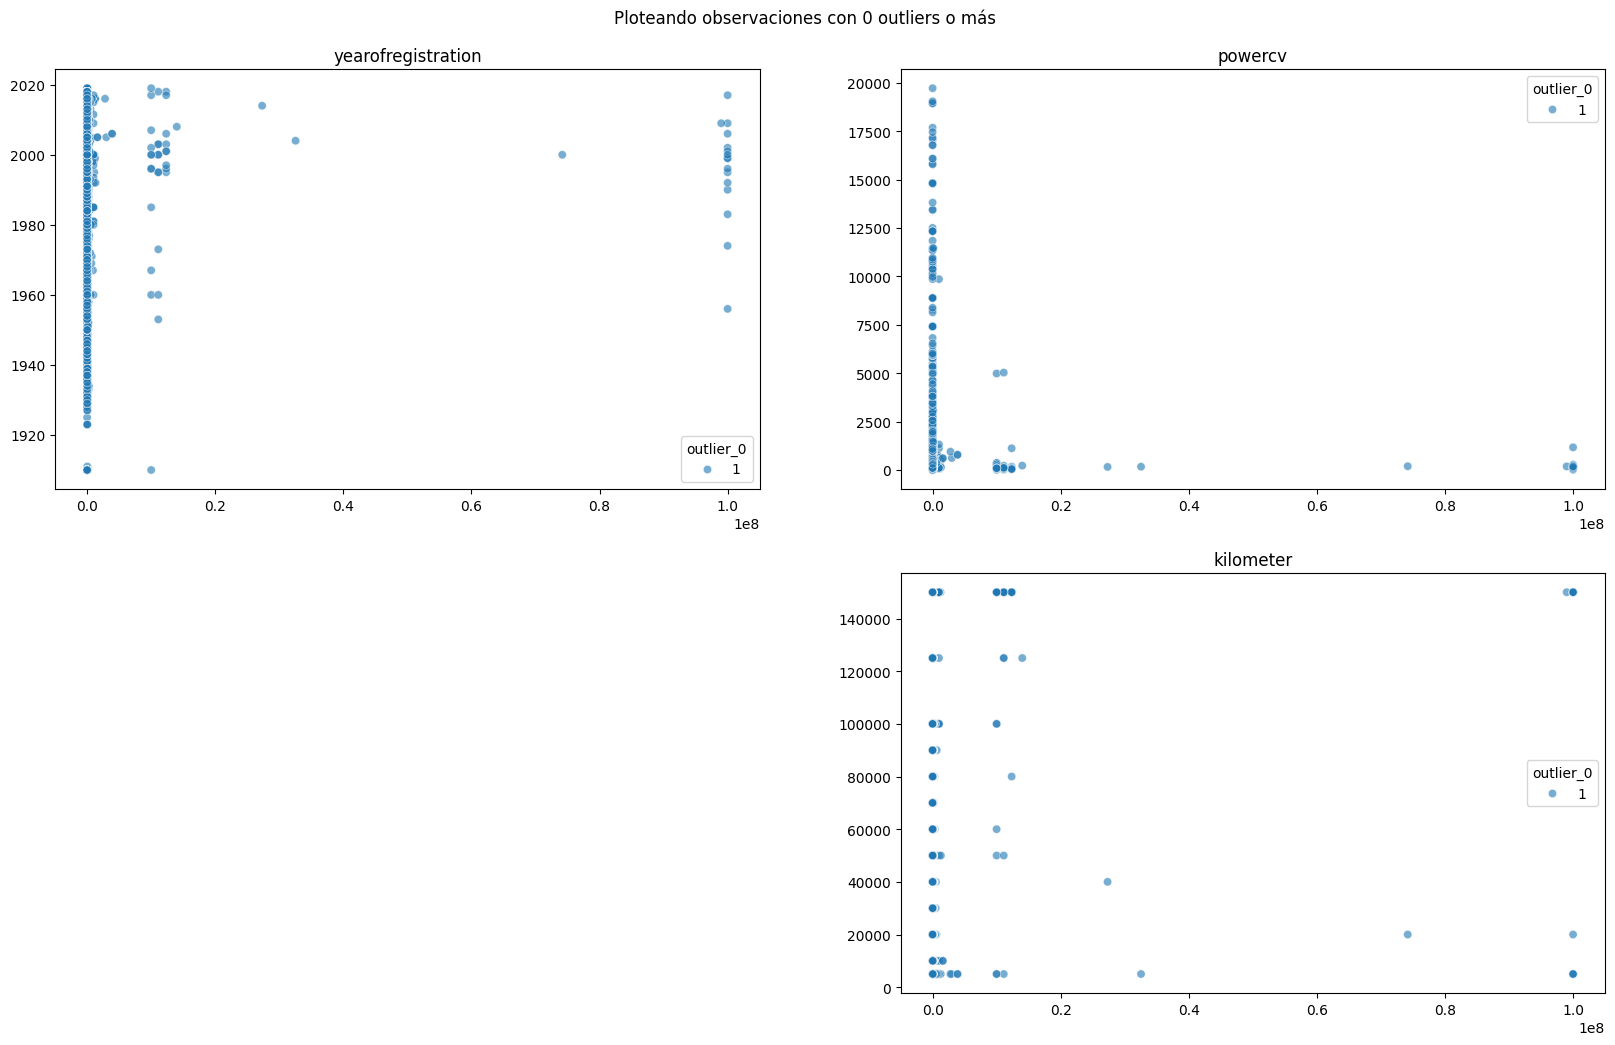

In [110]:
# para cada conteo, se crea una nueva columna
for count in autorenew_df["outlier_count"].unique():
    autorenew_df[f"outlier_{count}"] = np.where(autorenew_df["outlier_count"] >= count, 1, 0)

# plots bivariados en funcion del numero de veces que se ha considerado outlier
vr = "price"
tamano_grafica = (20,12)
num_cols = len(autorenew_df[["yearofregistration","powercv","price","kilometer"]].columns)
num_filas = math.ceil(num_cols / 2)

for count in list(reversed(sorted(autorenew_df["outlier_count"].unique()))):

    fig, axes = plt.subplots(num_filas, 2, figsize=tamano_grafica)
    plt.suptitle(f"Ploteando observaciones con {count} outliers o más", y=0.93)
    axes = axes.flat

    for ax, columna in zip(axes,autorenew_df[["yearofregistration","powercv","price","kilometer"]].columns):
        if columna == vr:
            fig.delaxes(ax)

        else:
            sns.scatterplot(x = vr, 
                            y = columna, 
                            data = autorenew_df,
                            hue=f"outlier_{count}",
                            ax = ax,
                            alpha=0.6)
        
        ax.set_title(columna)
        ax.set(xlabel=None, ylabel = None)

    plt.show()

A partir del análisis visual se obtiene que prácticamente todos los valores poco verosímiles, especialmente de la variable 'price0 con precios que superan los 100mil euros, son identificados como outliers incluso tomando solo observaciones con el conteo máximo de dicha etiqueta. De forma similar, los valores de 'powercv' también se suavizan. Sin embargo, la identificación como outlier de observaciones con 'yearofregistration' demasiado bajos es marginal, quedando muchos valores que siguen siendo considerados extremos y que generan poca confianza. 

De forma previa a la inspección de detalle a partir de las tablas, se va a proceder a la detección mediante el método Isolation Forest para la combinación entre ambos.

### 4.2 Método Isolation Forest

A continuación, al igual que se hizo con LOF, se introducen al Isolation Forest las 4 columnas numéricas de estudio para detectar outliers multivariados.

In [ ]:
n_estimators = [1000,2000]
contaminacion = [0.01,0.05,0.1]
combinaciones = list(product(n_estimators,contaminacion))

df_if_total = pd.DataFrame()
for n_estimators, contaminacion in combinaciones:
    df_if = gestor_outliers_multi.detectar_outliers_if(contaminacion=contaminacion,n_estimators=n_estimators)
    df_if = df_if[["outlier"]]
    df_if.rename(columns={"outlier":f"outliers_if_{contaminacion}_{n_estimators}"},inplace=True)
    df_if_total = pd.concat([df_if_total,df_if],axis=1)

df_if_total.head()

Se repite la aproximación de inspeccionar el efecto de detección de outliers por consenso de combinaciones más allá de centrarse en una sola combinación.

In [ ]:
df_if_total_copy = df_if_total.copy()
df_if_total_copy.replace({-1:1,1:0},inplace=True)
# autorenew_df["total_outlier_if"] = np.where(df_lof_total_copy.mean(axis=1) == 1, 1,0).astype("O")
autorenew_df["outlier_if_num_count"] = df_if_total_copy.sum(axis=1)

sns.countplot(data=autorenew_df,x="outlier_if_count")

NameError: name 'df_if_total' is not defined

Llama a la atención el hecho de que el número de outliers encontrados en las distintas iteraciones aumente prácticamente de forma par. Esto viene posiblemente explicado por el hecho de que los isolation forest de 1000 estimadores y 2000 estimadores coinciden en la mayoría de casos. Por ejemplo, si el IF de 0.01 de contaminación para 1000 estimadores no encuentra outliers, en la mayoría de casos el de 2000 tampoco lo hace y viceversa. Esto viene a indicar que la precisión de 1000 estimadores Vs 2000 no varía mucho y que si trazaramos una curva de inercia, habríamos pasado probablemente ya la curva del "codo". Esta visualización no se realiza principalmente for falta de tiempo para computar los puntos de la curva.

Ahora, graficando los efectos para, de nuevo, observar principalmente la restricción de rangos susceptibles de representar outliers.

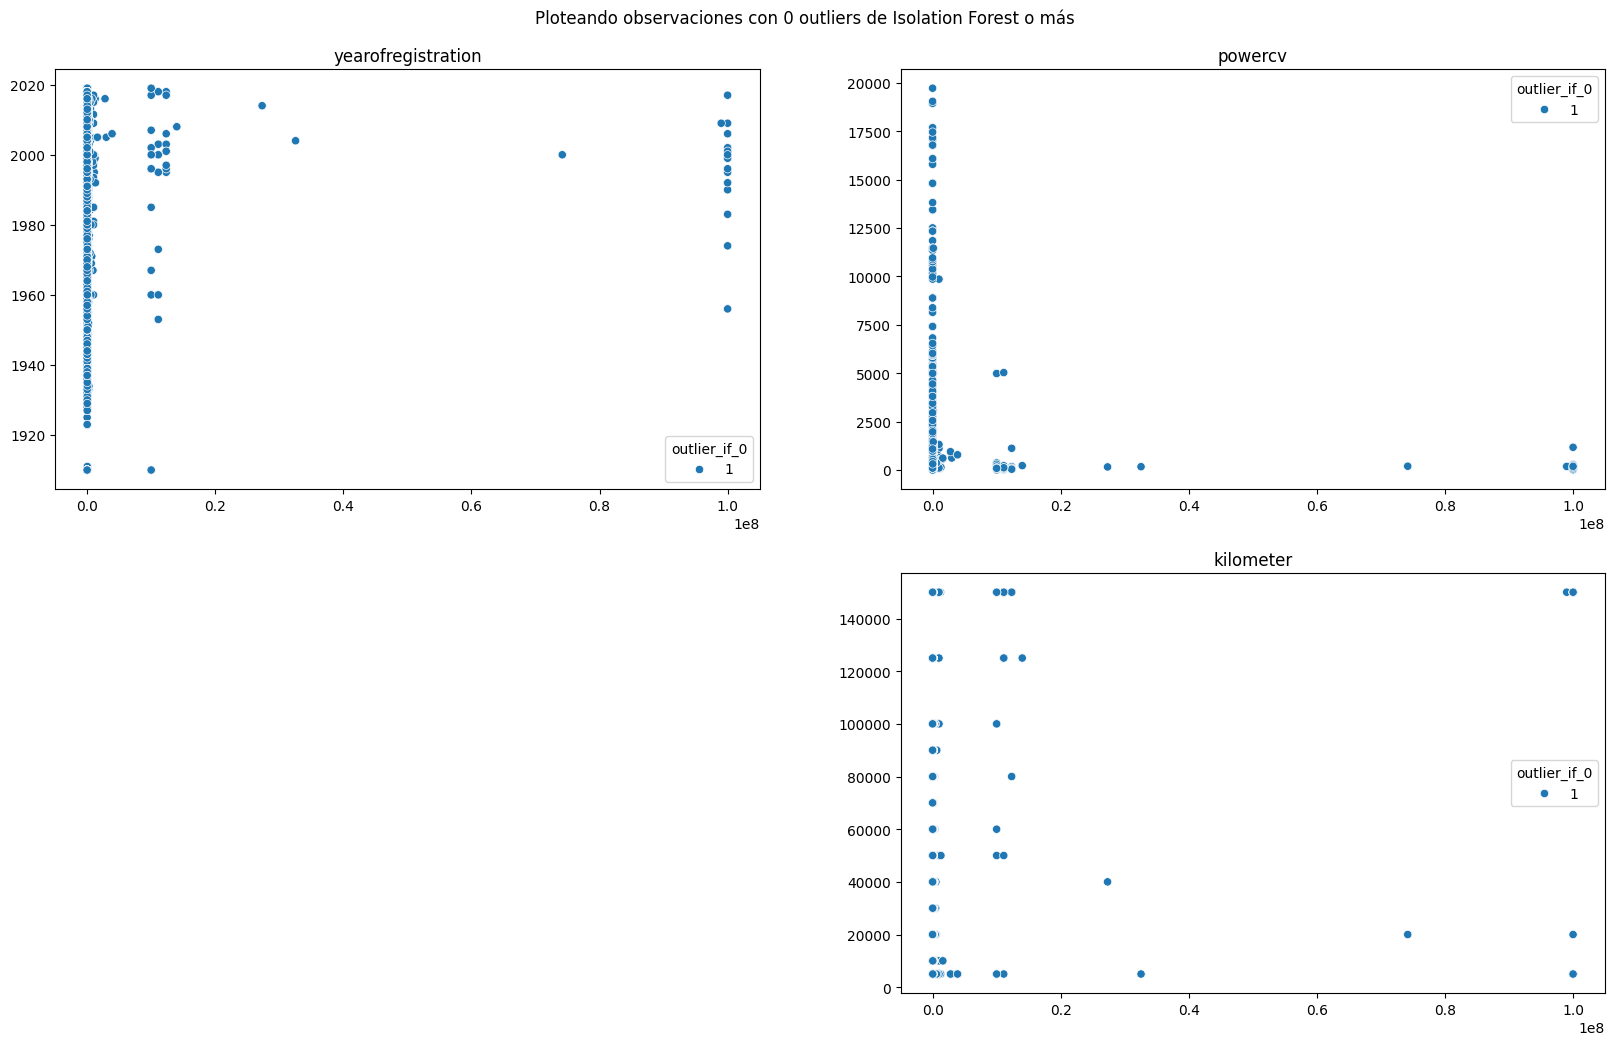

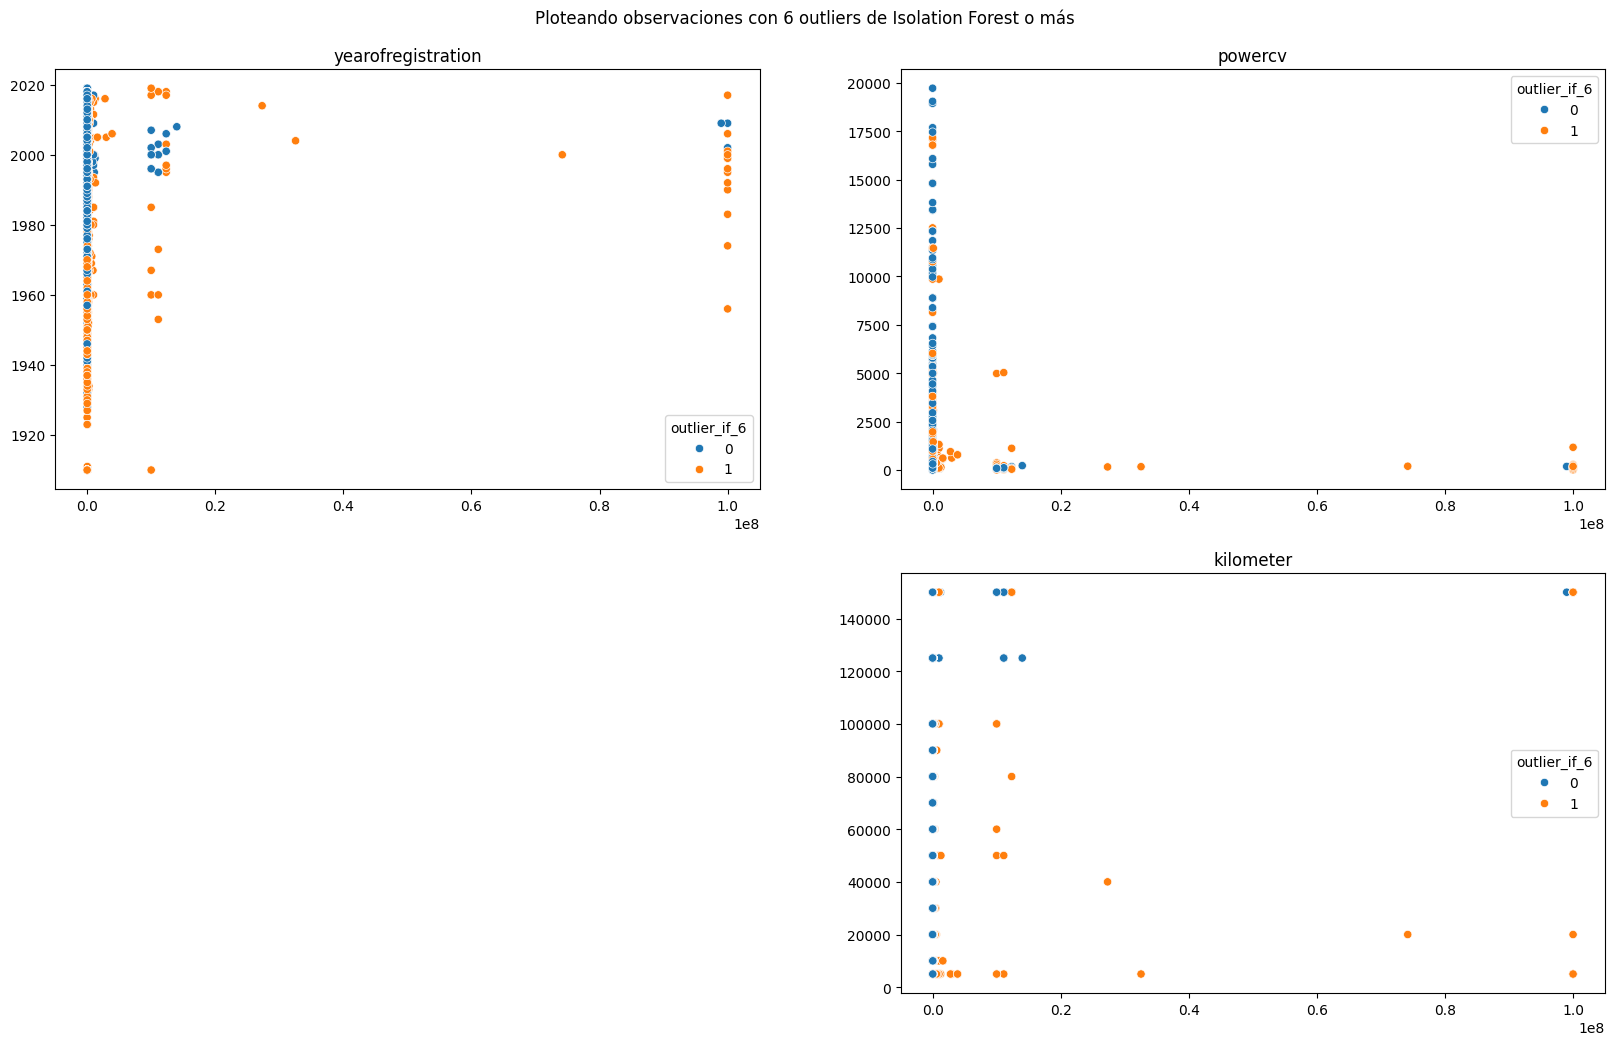

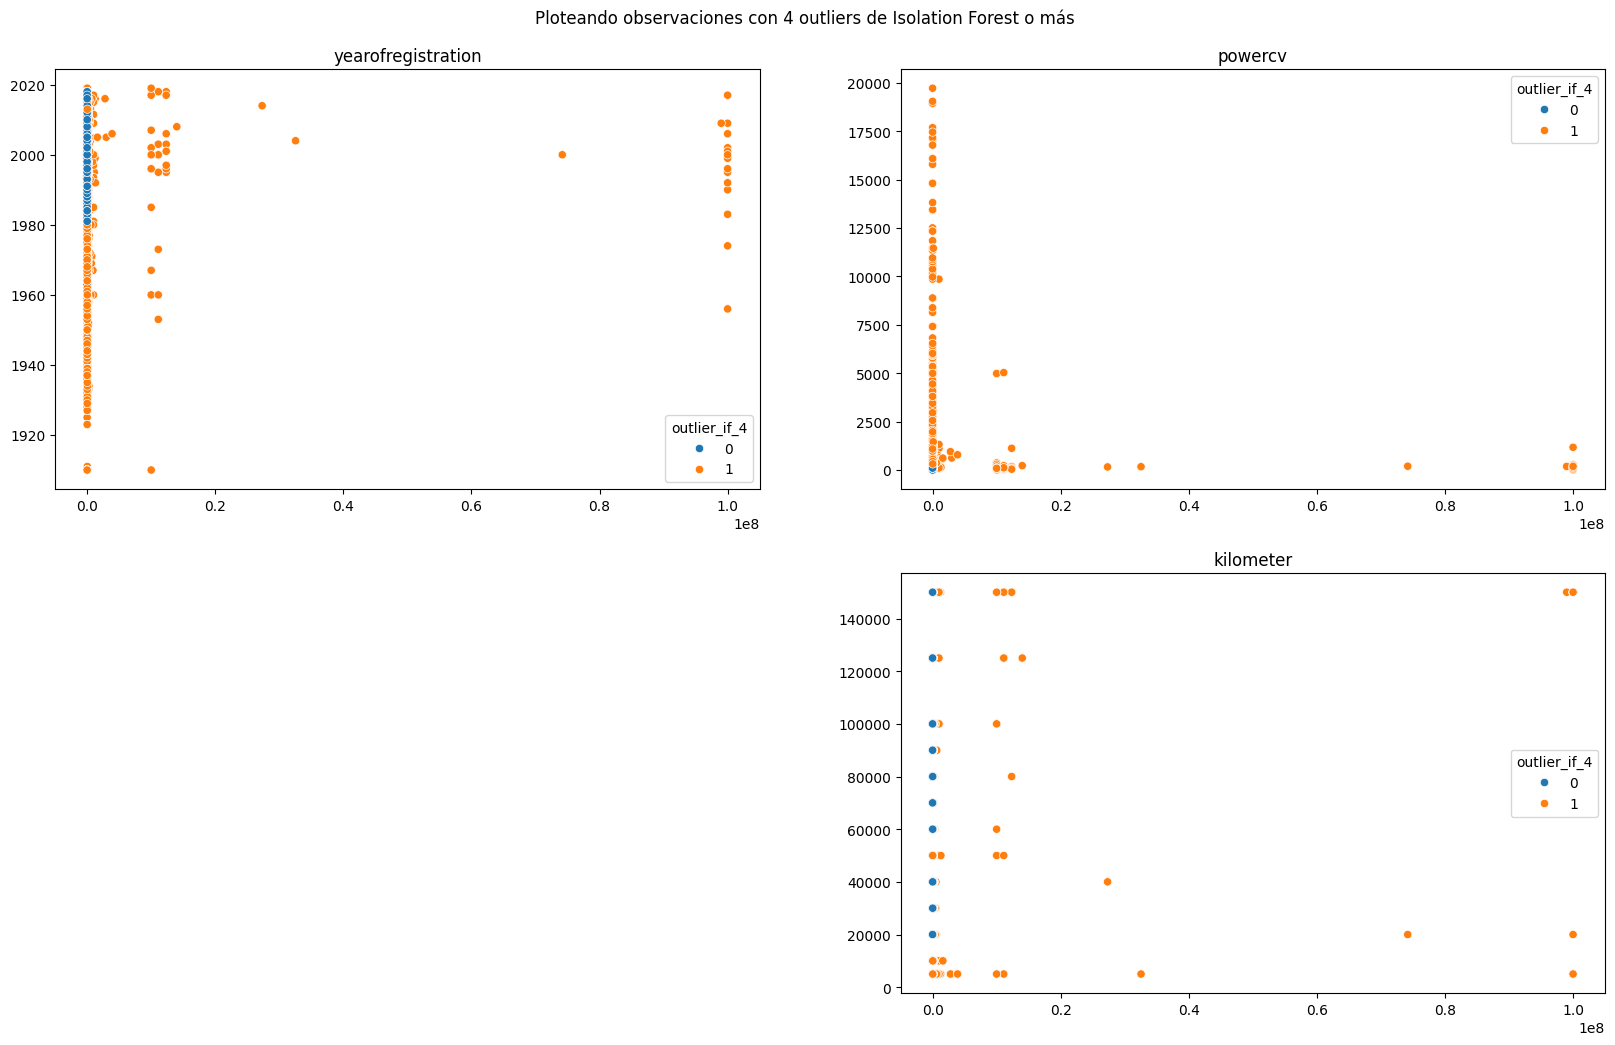

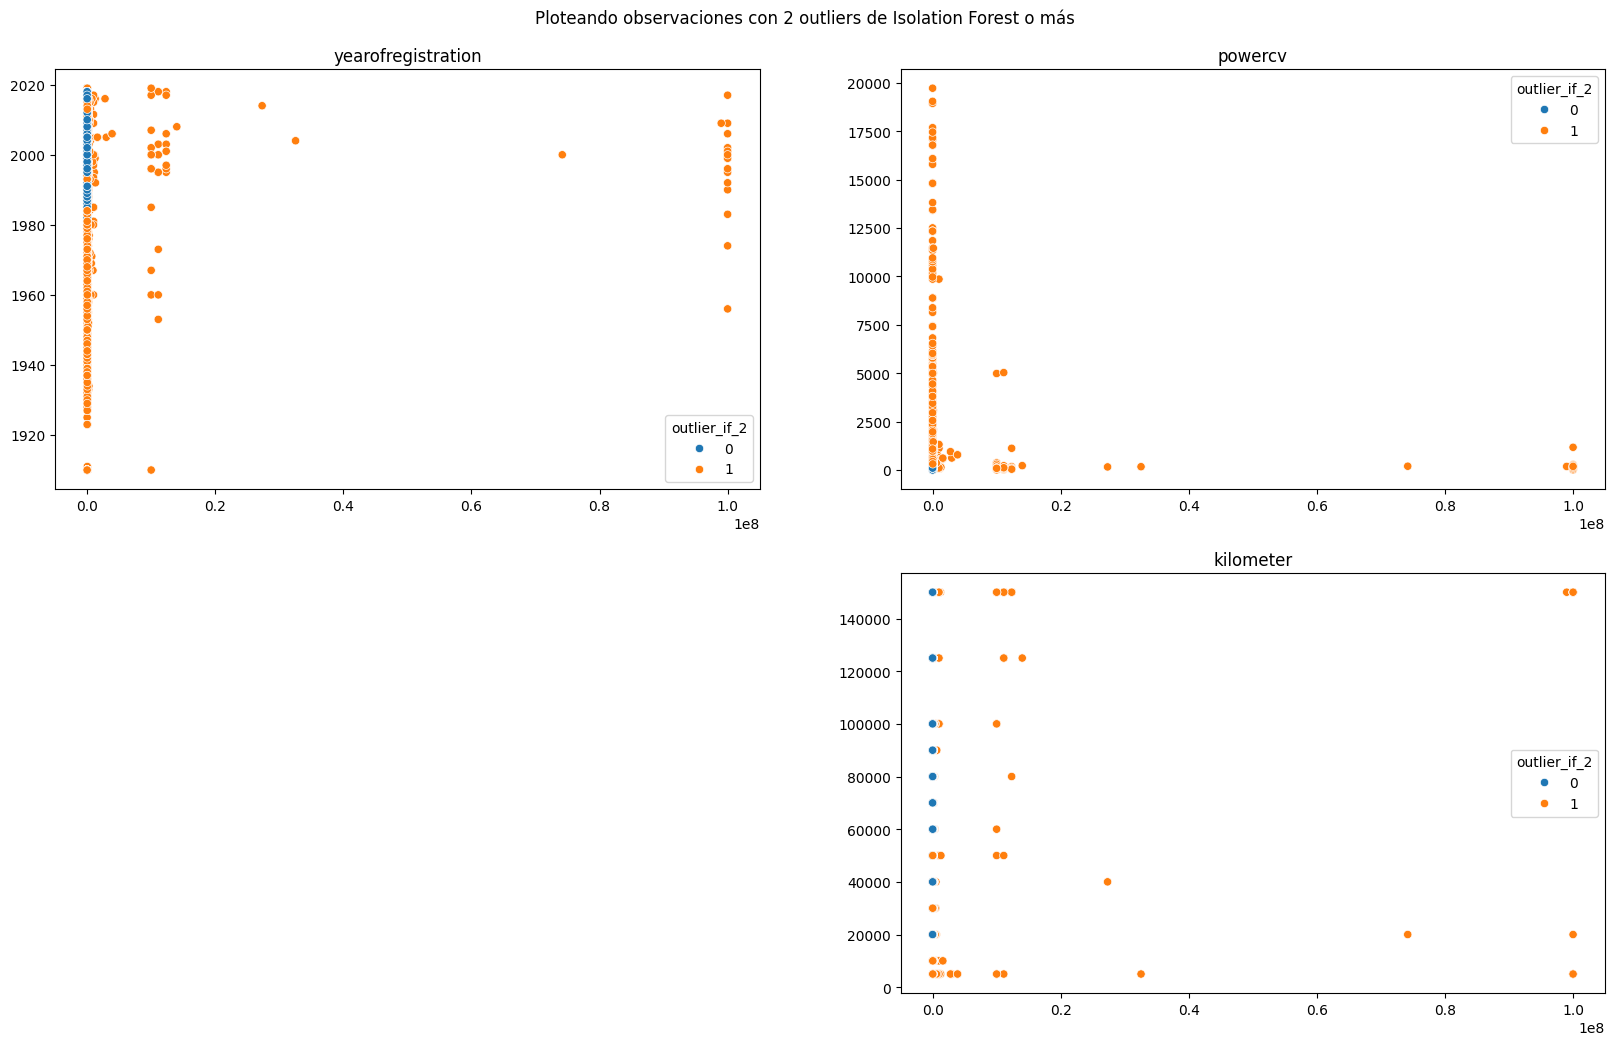

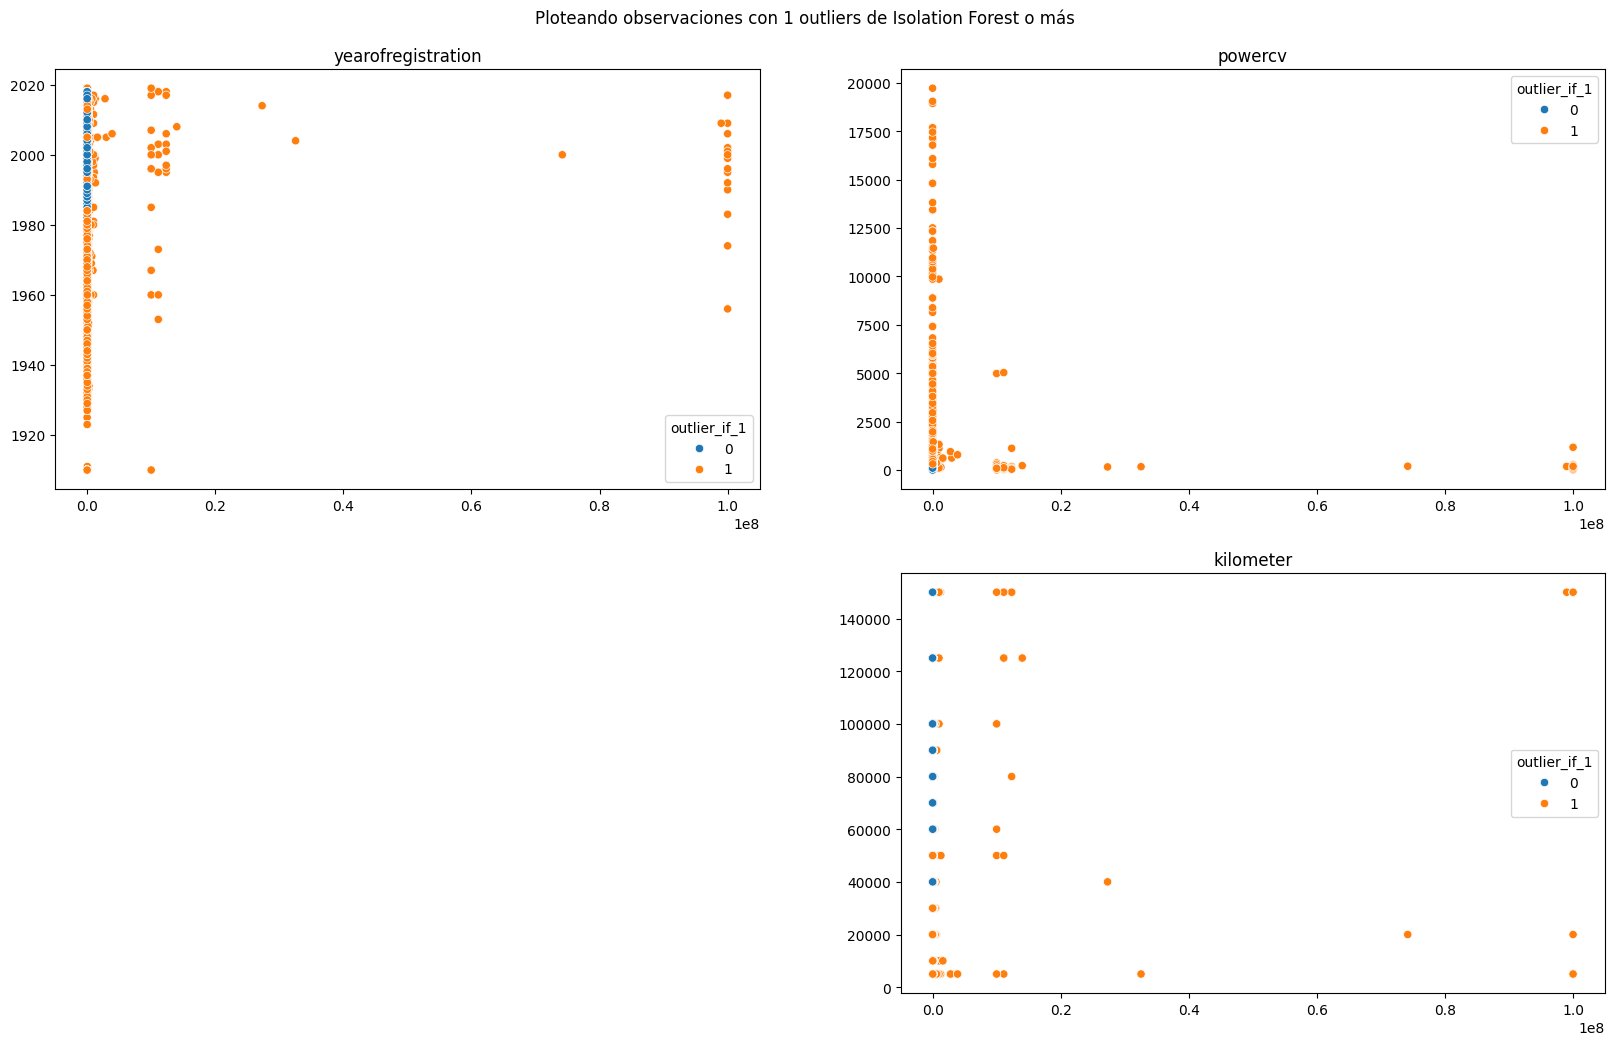

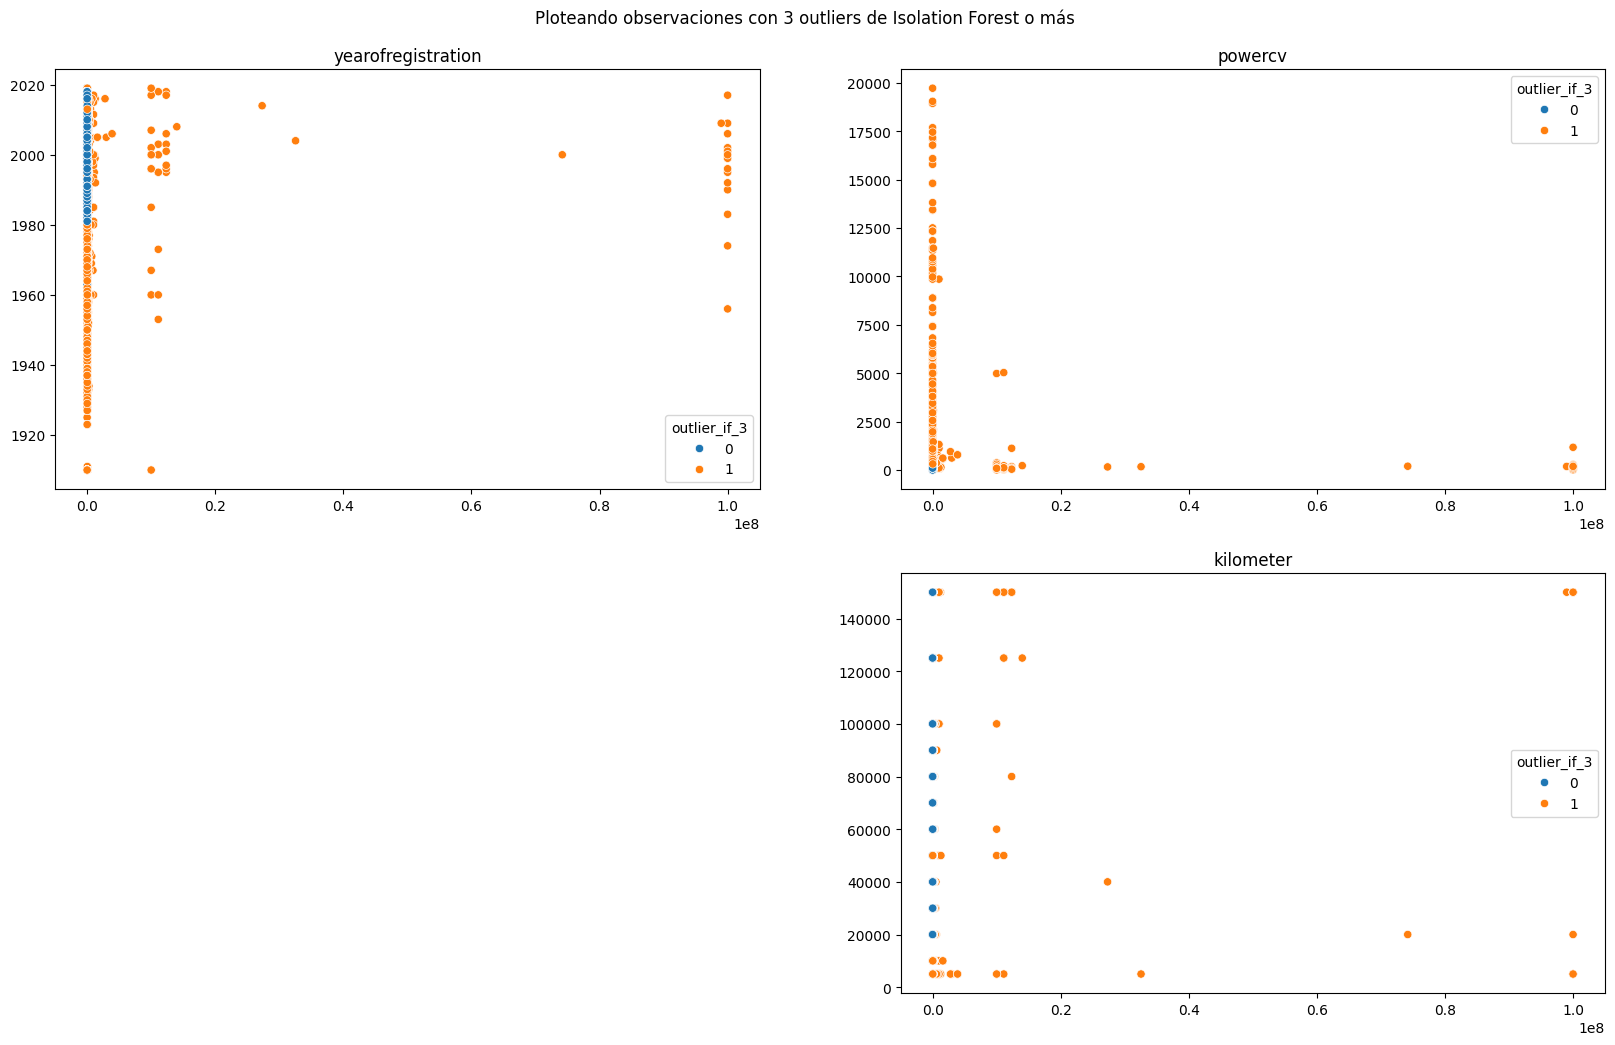

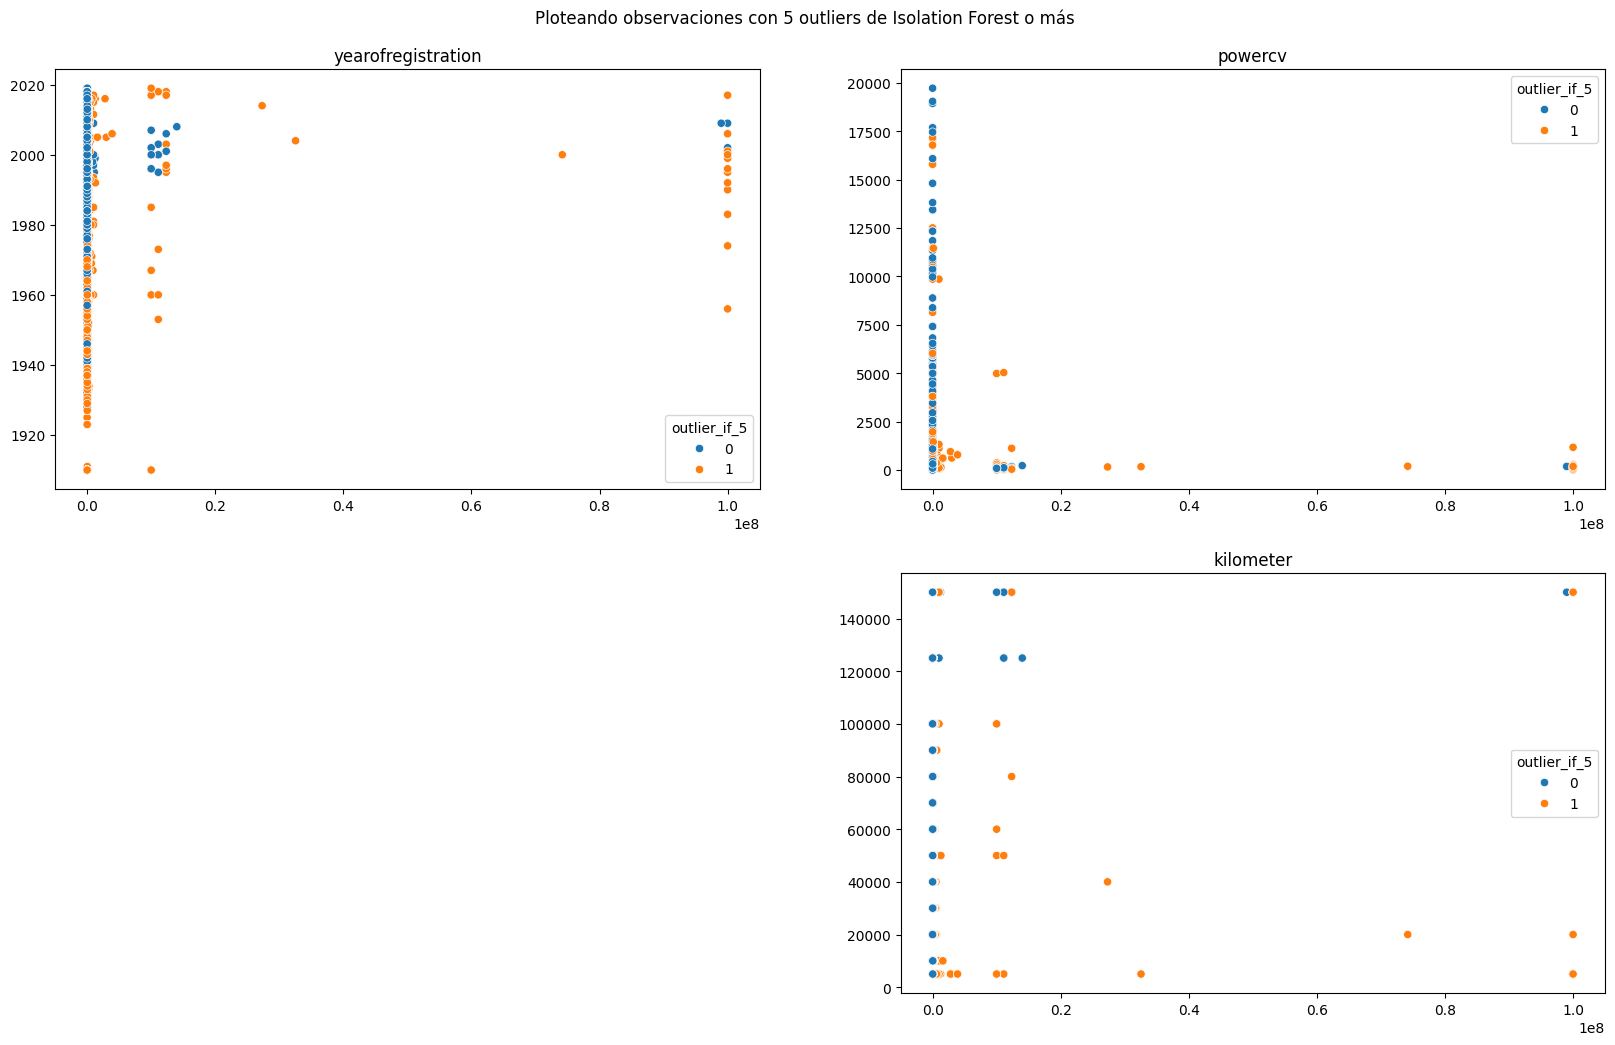

In [ ]:
# para cada conteo, se crea una nueva columna
for count in autorenew_df["outlier_if_num_count"].unique():
    autorenew_df[f"outlier_if_num_{count}"] = np.where(autorenew_df["outlier_if_num_count"] >= count, 1, 0)

vr = "price"
tamano_grafica = (20,12)
num_cols = len(autorenew_df[["yearofregistration","powercv","price","kilometer"]].columns)
num_filas = math.ceil(num_cols / 2)

for count in autorenew_df["outlier_if_num_count"].unique():

    fig, axes = plt.subplots(num_filas, 2, figsize=tamano_grafica)
    plt.suptitle(f"Ploteando observaciones con {count} outliers de Isolation Forest o más", y=0.93)
    axes = axes.flat

    for ax, columna in zip(axes,autorenew_df[["yearofregistration","powercv","price","kilometer"]].columns):
        if columna == vr:
            fig.delaxes(ax)

        else:
            sns.scatterplot(x = vr, 
                            y = columna, 
                            data = autorenew_df,
                            hue=f"outlier_if_num_{count}",
                            ax = ax,
                            alpha=0.5)
        
        ax.set_title(columna)
        ax.set(xlabel=None, ylabel = None)

    plt.show()

### 4.3 Isolation Forest - añadiendo variables categóricas

In [ ]:
cols_to_encode = ["fueltype","brand","vehicletype"]

binary_encoder = ce.BinaryEncoder(cols=cols_to_encode)

# Fit and Transform the data
autorenew_df_encoded = binary_encoder.fit_transform(autorenew_df)

In [ ]:
encoded_category_colums = [col for col_encoded in cols_to_encode 
                           for col in autorenew_df_encoded.columns.to_list() 
                           if col.startswith(col_encoded)]

encoded_category_colums.extend(["yearofregistration","powercv","price","kilometer"])

In [ ]:
gestor_outliers_multivariado = so.GestionOutliersMultivariados(autorenew_df_encoded[encoded_category_colums])

In [ ]:
n_estimators = [1000,2000]
contaminacion = [0.01,0.05,0.1]
combinaciones = list(product(n_estimators,contaminacion))

df_if_cat_total = pd.DataFrame()
for n_estimators, contaminacion in combinaciones:
    df_if_cat = gestor_outliers_multi.detectar_outliers_if(contaminacion=contaminacion,n_estimators=n_estimators)
    df_if_cat = df_if_cat[["outlier"]]
    df_if_cat.rename(columns={"outlier":f"outliers_if_{contaminacion}_{n_estimators}"},inplace=True)
    df_if_cat_total = pd.concat([df_if_cat_total,df_if_cat],axis=1)

df_if_cat_total

,outliers_if_0.01_1000,outliers_if_0.05_1000,outliers_if_0.1_1000,outliers_if_0.01_2000,outliers_if_0.05_2000,outliers_if_0.1_2000
0,1,1,1,1,1,1
1,1,1,1,1,1,1
2,1,1,1,1,1,1
3,1,1,1,1,1,1
4,1,1,1,1,1,1
...,...,...,...,...,...,...
360740,1,1,-1,1,1,1
360741,1,1,1,1,1,1
360742,1,1,1,1,1,1
360743,1,1,1,1,1,1


<Axes: xlabel='outlier_if_count', ylabel='count'>

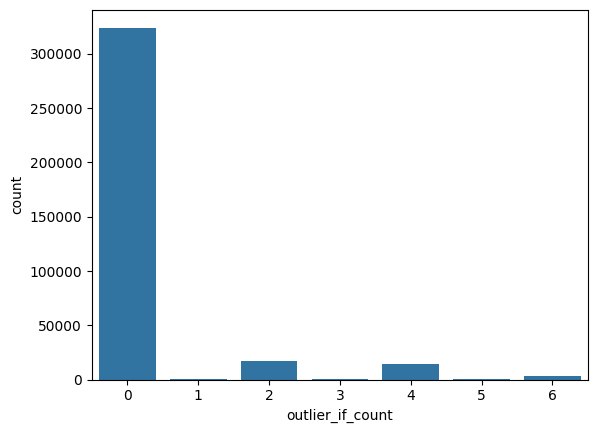

In [ ]:
df_if_cat_total_copy = df_if_cat_total.copy()
df_if_cat_total_copy.replace({-1:1,1:0},inplace=True)
autorenew_df["outlier_if_cat_count"] = df_if_cat_total_copy.sum(axis=1)
autorenew_df["outlier_if_cat_count"]

sns.countplot(data=autorenew_df,x="outlier_if_cat_count")

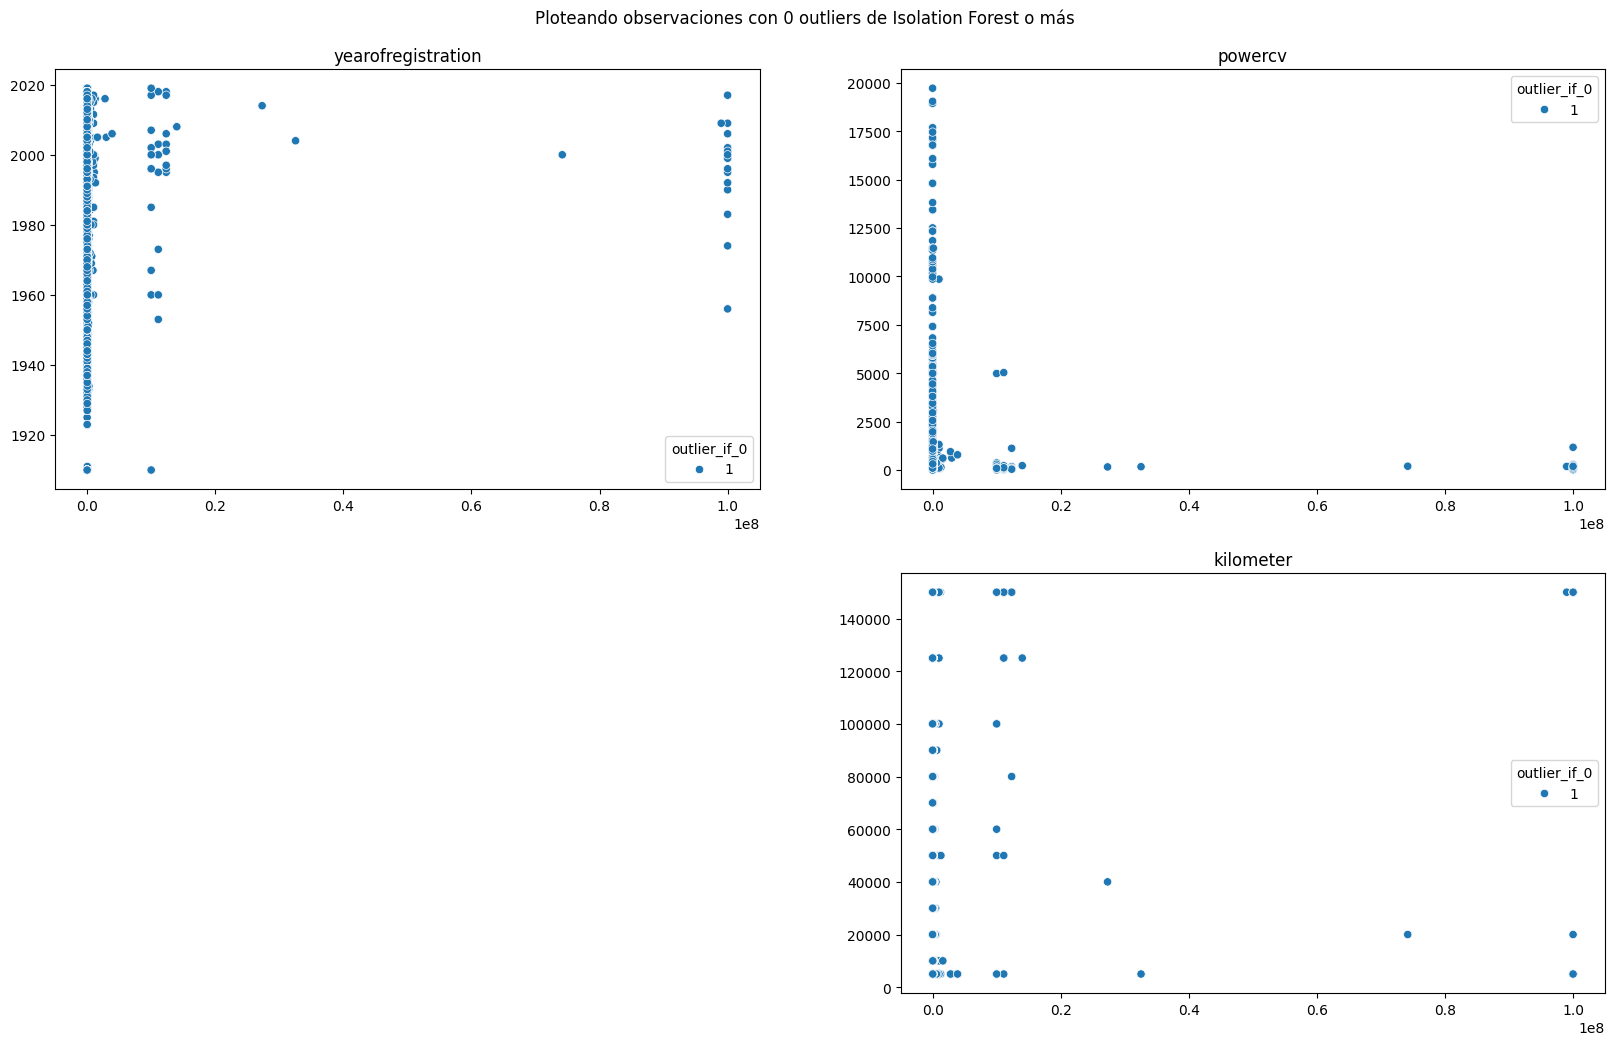

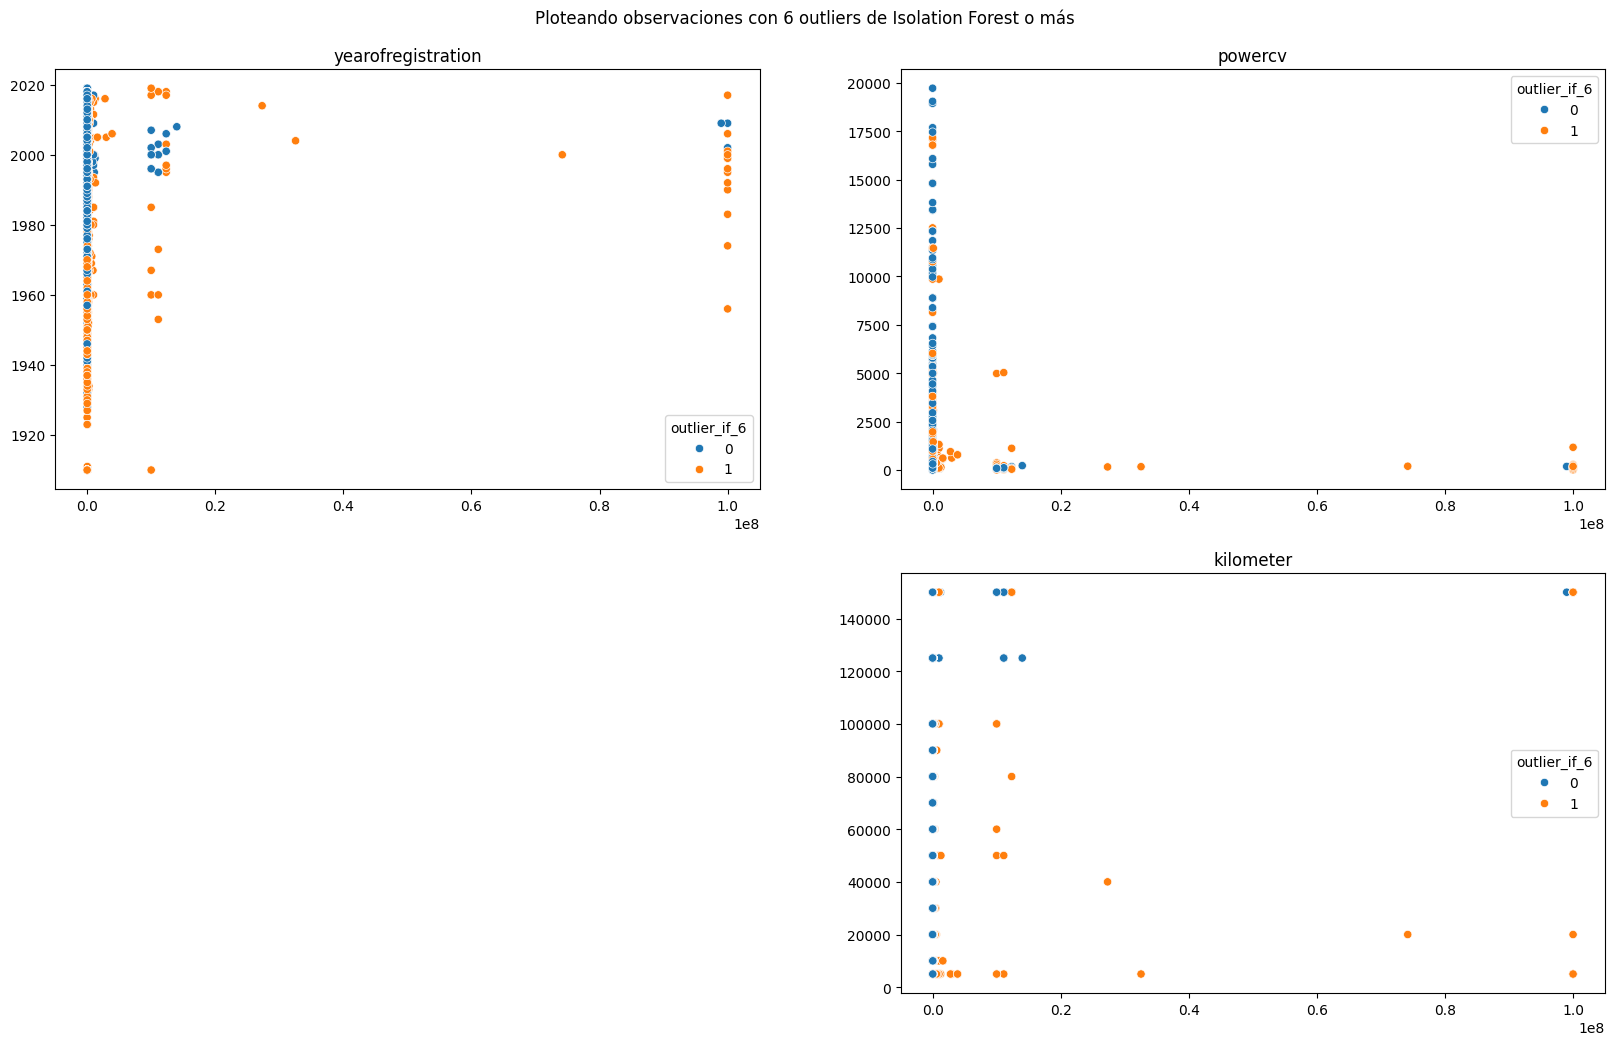

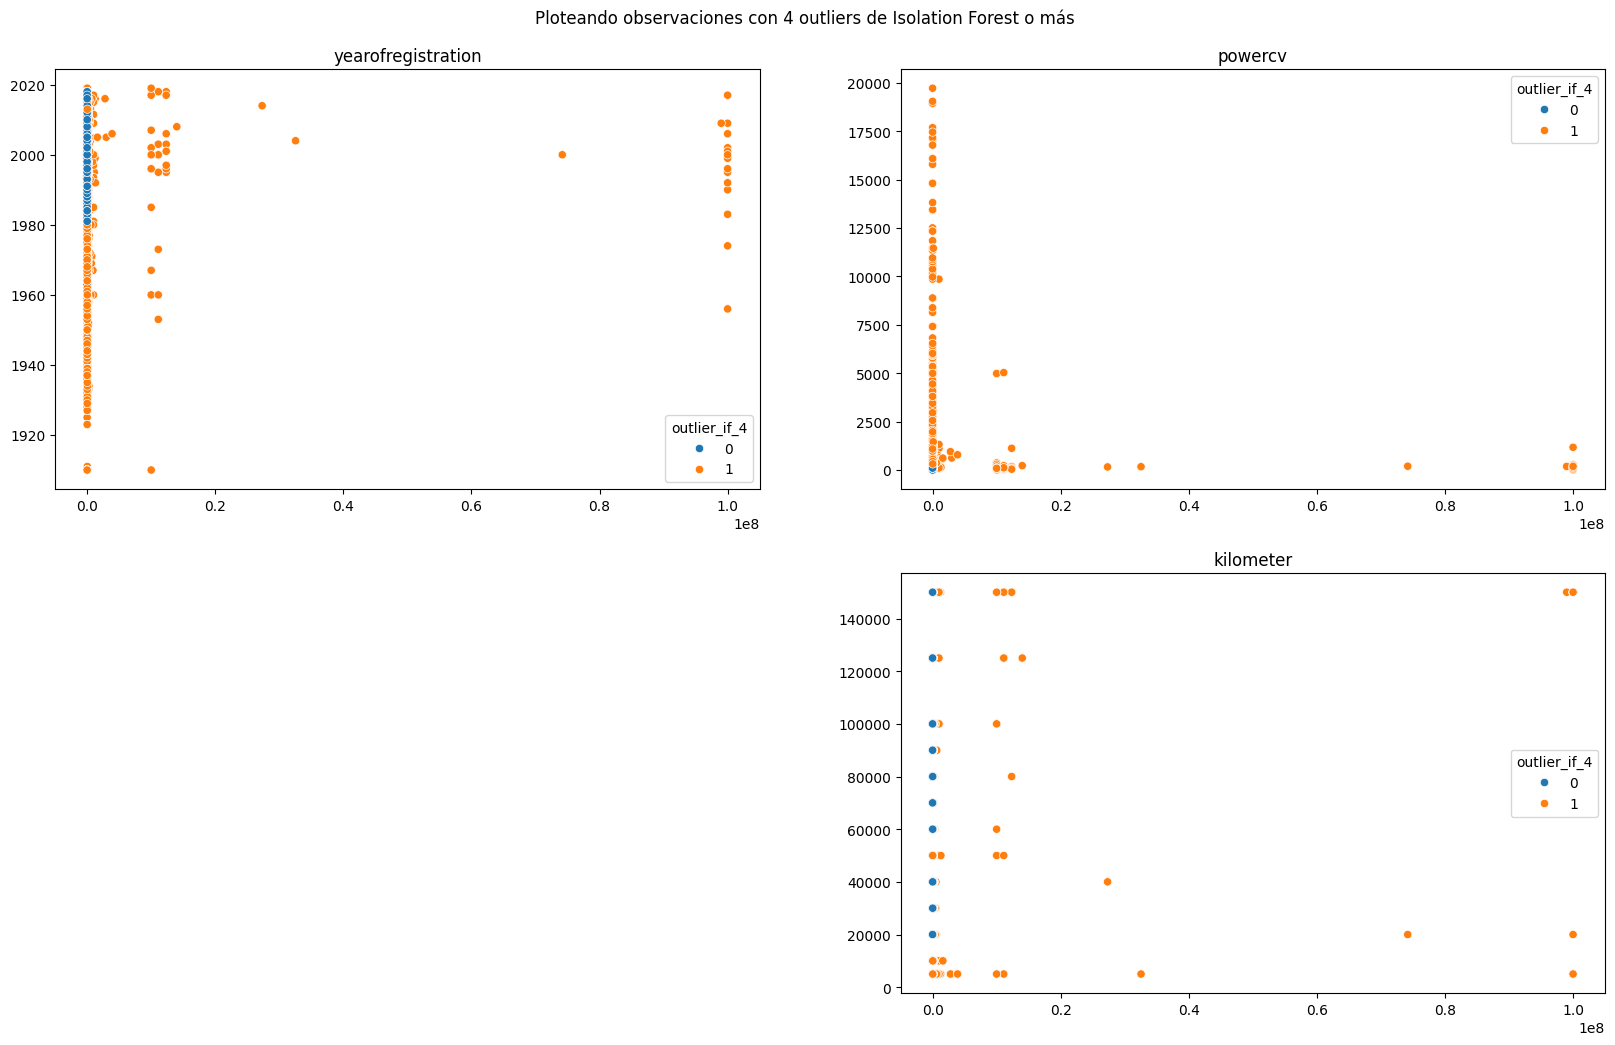

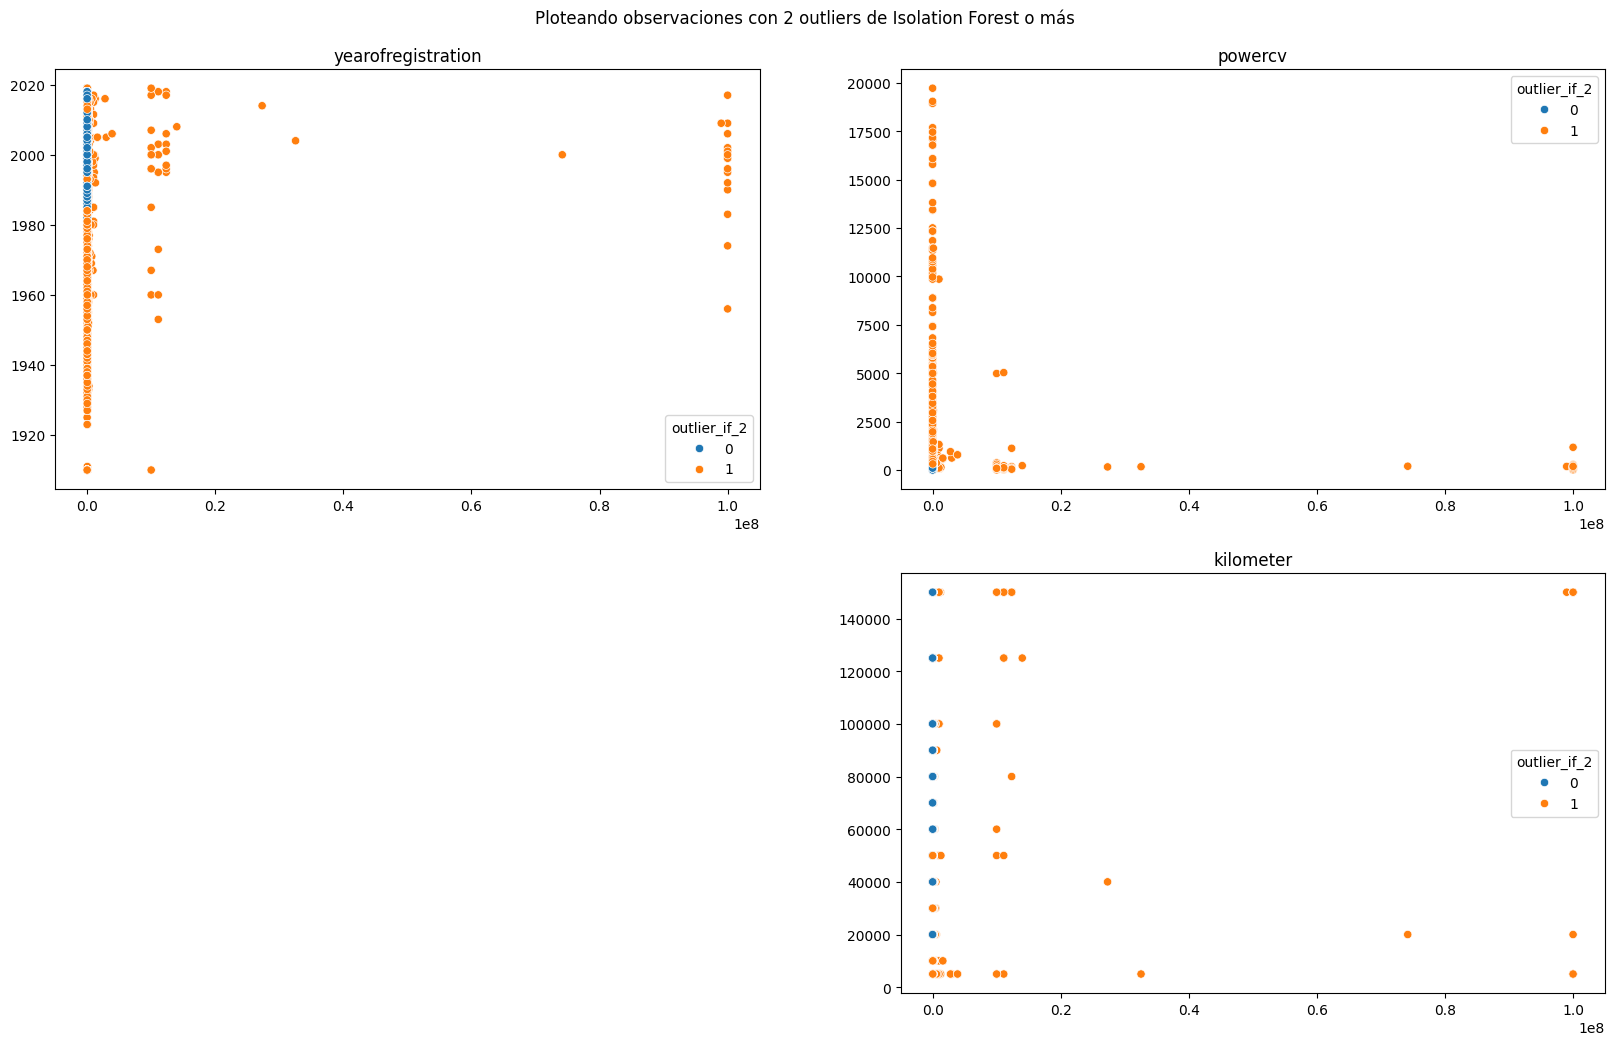

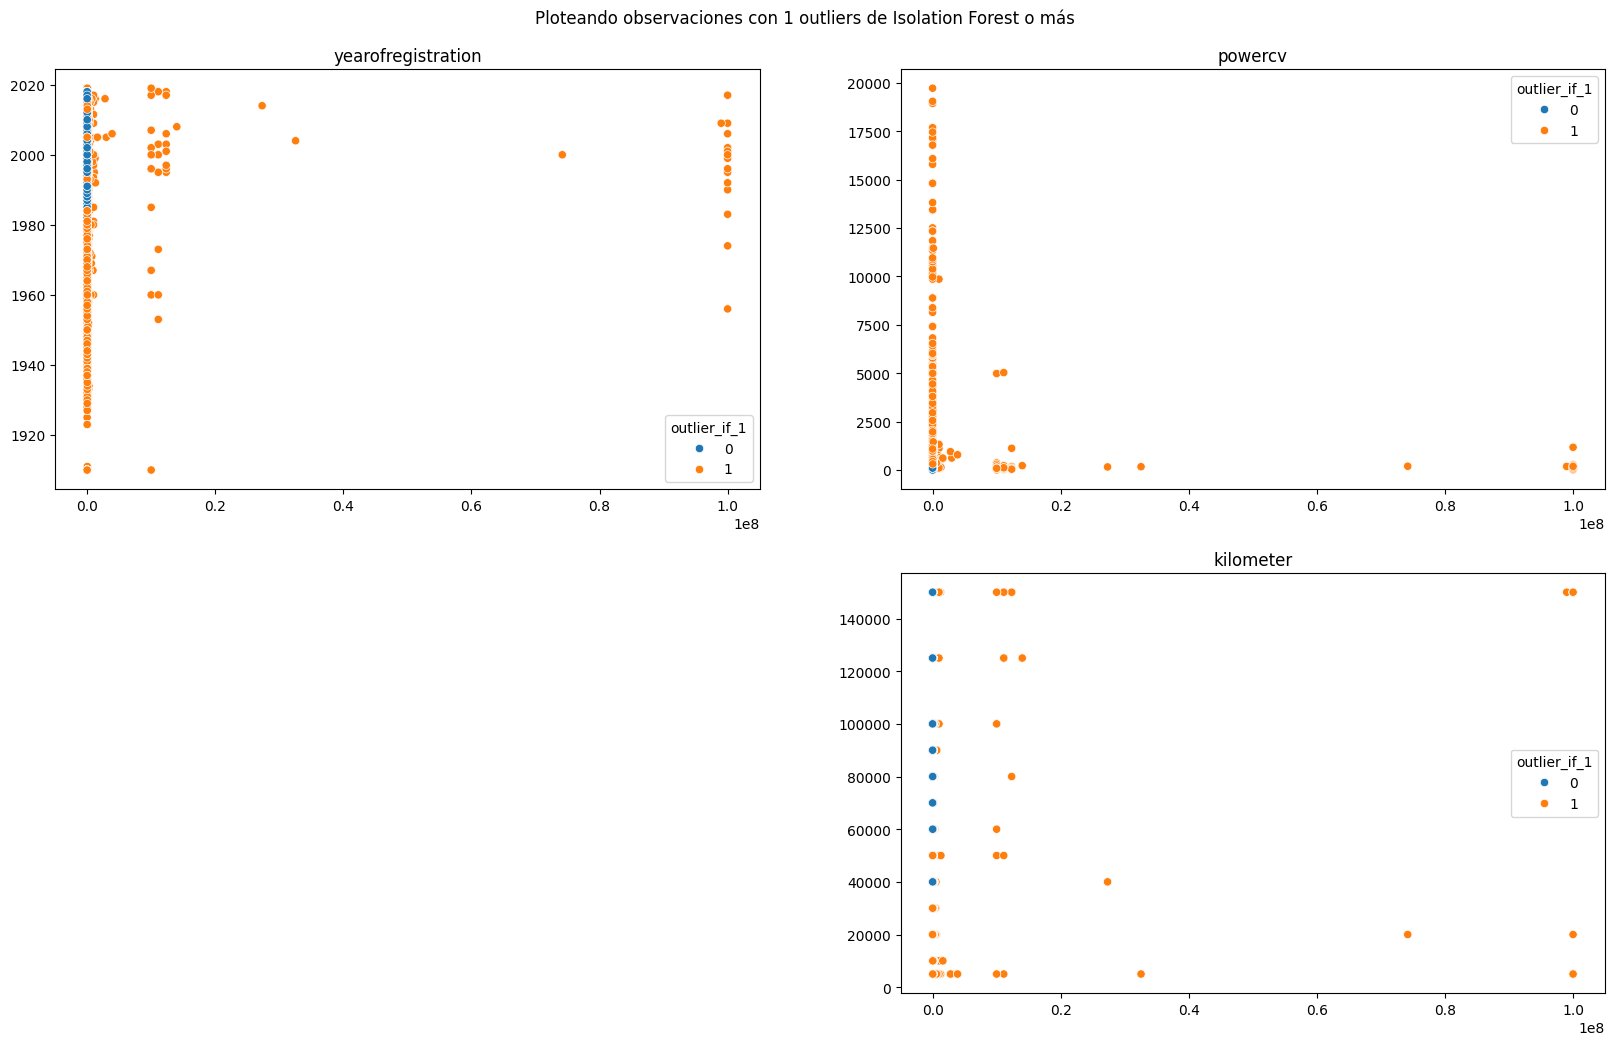

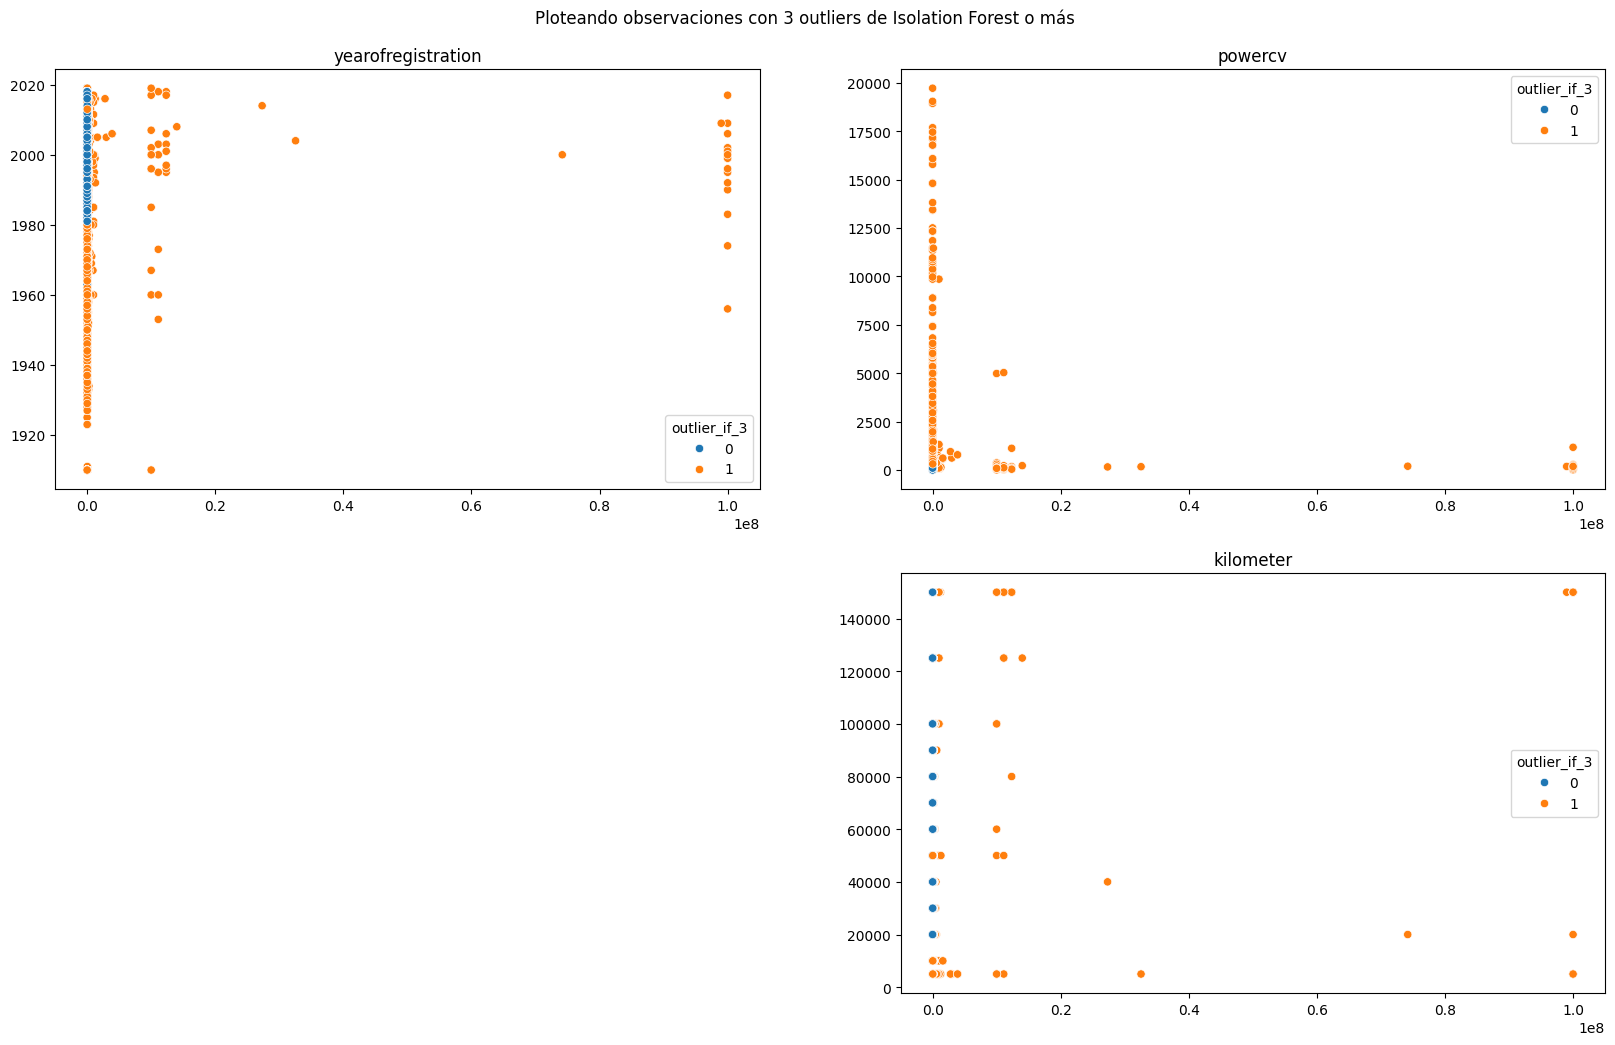

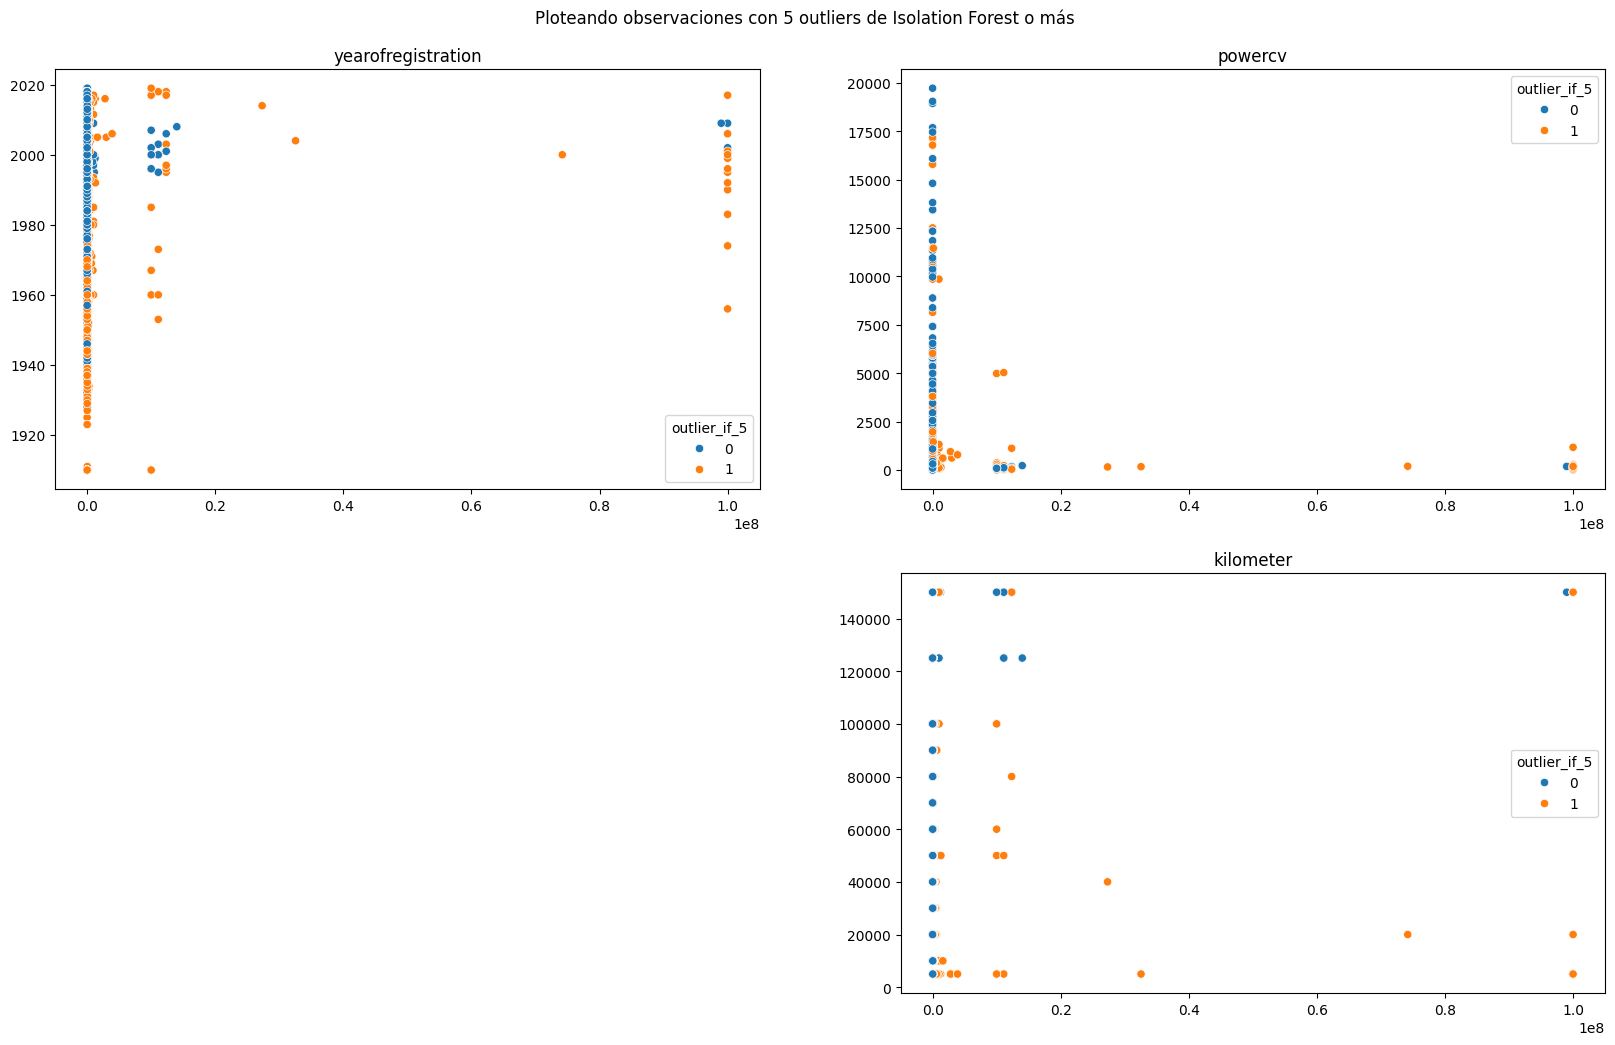

In [ ]:
for count in autorenew_df["outlier_if_cat_count"].unique():
    autorenew_df[f"outlier_if_cat_{count}"] = np.where(autorenew_df["outlier_if_cat_count"] >= count, 1, 0)

vr = "price"
tamano_grafica = (20,12)
num_cols = len(autorenew_df[["yearofregistration","powercv","price","kilometer"]].columns)
num_filas = math.ceil(num_cols / 2)

for count in list(reversed(sorted(autorenew_df["outlier_if_cat_count"].unique()))):

    fig, axes = plt.subplots(num_filas, 2, figsize=tamano_grafica)
    plt.suptitle(f"Ploteando observaciones con {count} outliers de Isolation Forest o más", y=0.93)
    axes = axes.flat

    for ax, columna in zip(axes,autorenew_df[["yearofregistration","powercv","price","kilometer"]].columns):
        if columna == vr:
            fig.delaxes(ax)

        else:
            sns.scatterplot(x = vr, 
                            y = columna, 
                            data = autorenew_df,
                            hue=f"outlier_if_cat_{count}",
                            ax = ax)
        
        ax.set_title(columna)
        ax.set(xlabel=None, ylabel = None)

    plt.show()

In [ ]:
# save 
autorenew_df.to_parquet("../datos/autorenew_outliers.parquet")

Numerically comparing the LoF and Isolation Forest methods:

In [36]:
autorenew_df.filter(like="outlier")

,total_outlier,outlier_count,outlier_5,outlier_0,outlier_3,outlier_1,outlier_2,outlier_4,outlier_6,outlier_if_count,outlier_if_0,outlier_if_6,outlier_if_4,outlier_if_2,outlier_if_1,outlier_if_3,outlier_if_5
0,0,5,1,1,1,1,1,1,0,0,1,0,0,0,0,0,0
1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360740,0,0,0,1,0,0,0,0,0,1,1,0,0,0,1,0,0
360741,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
360742,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
360743,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0


Let's inspect the range of years for the different amounts of outliers:

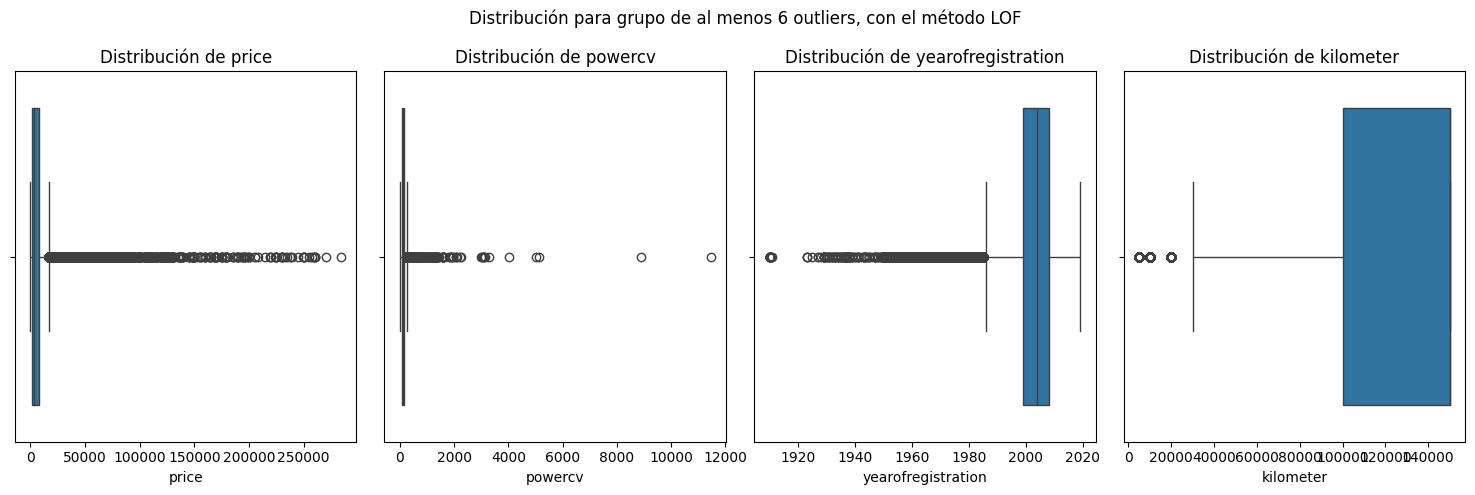

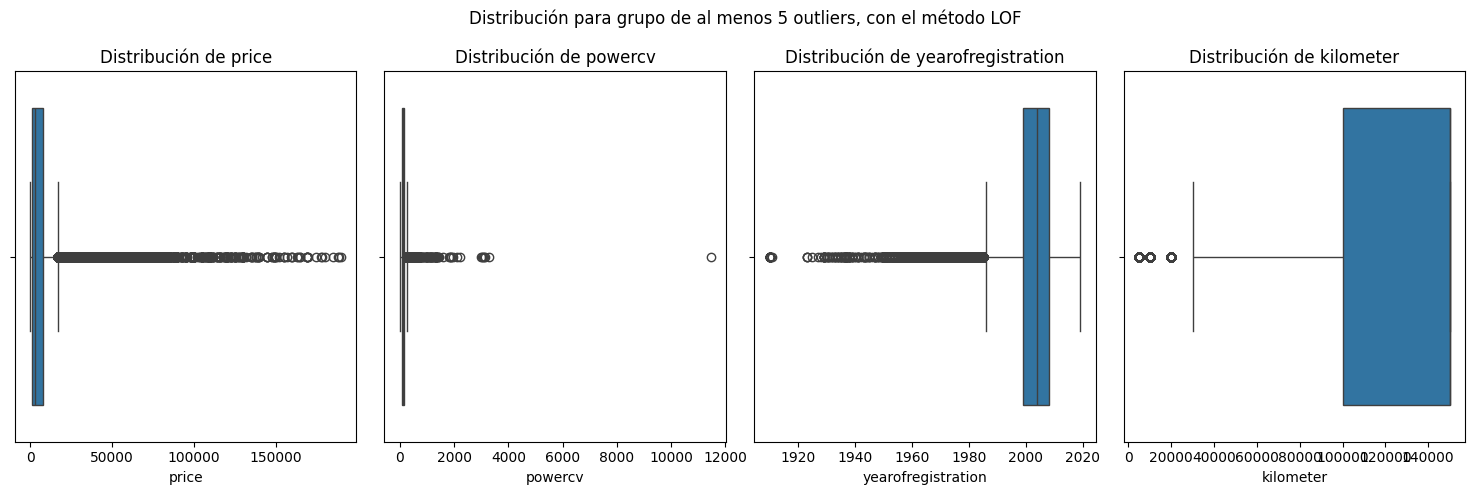

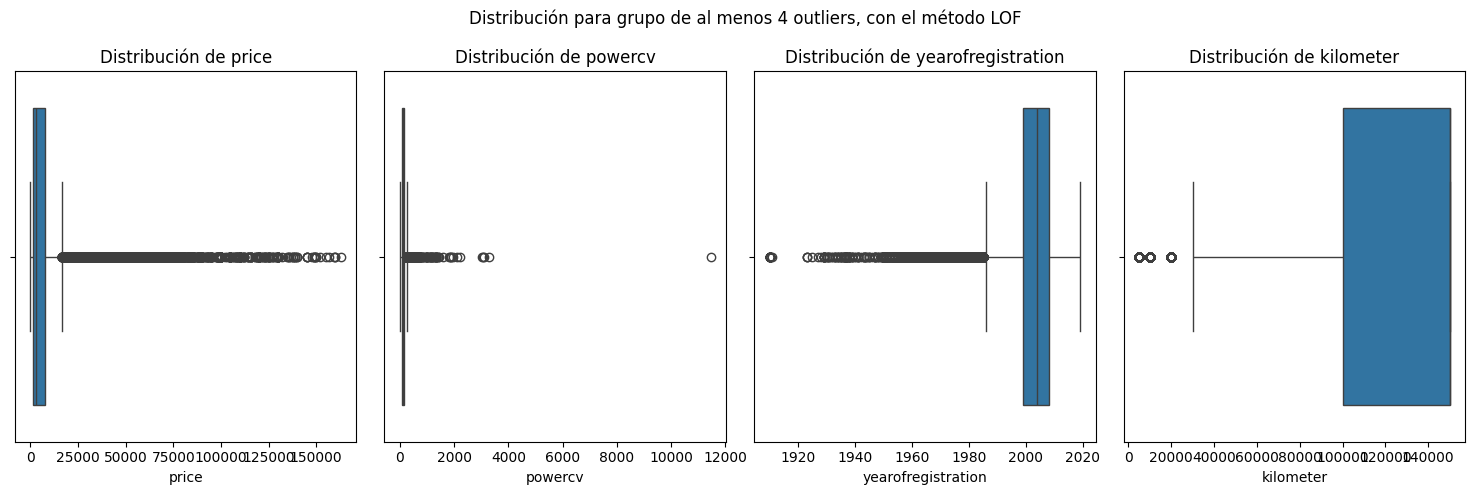

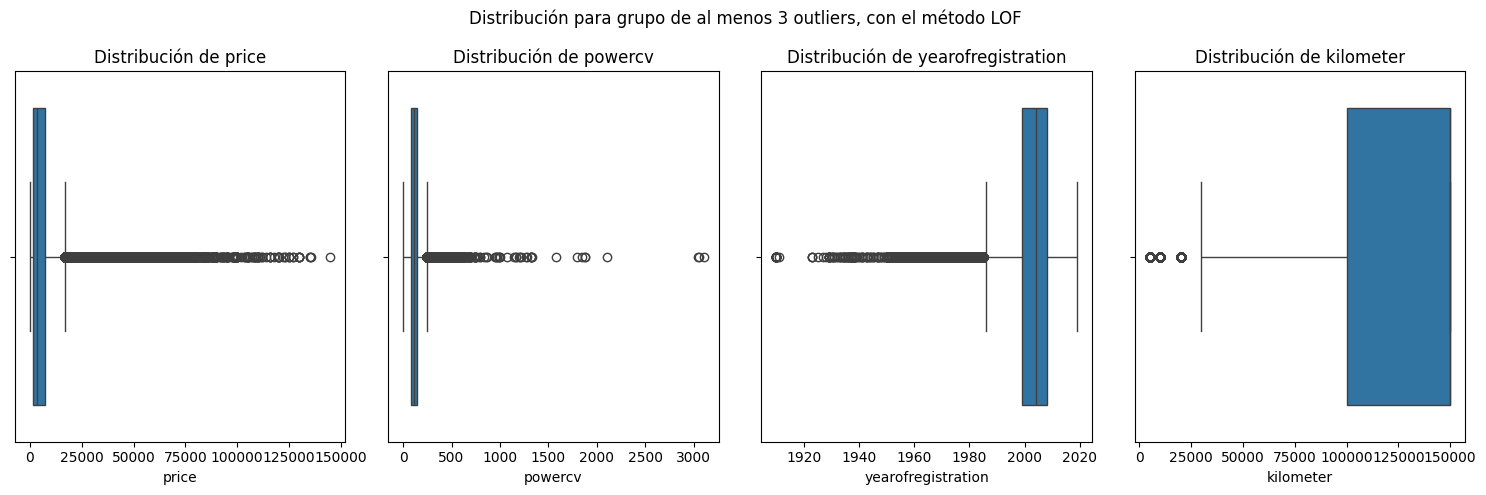

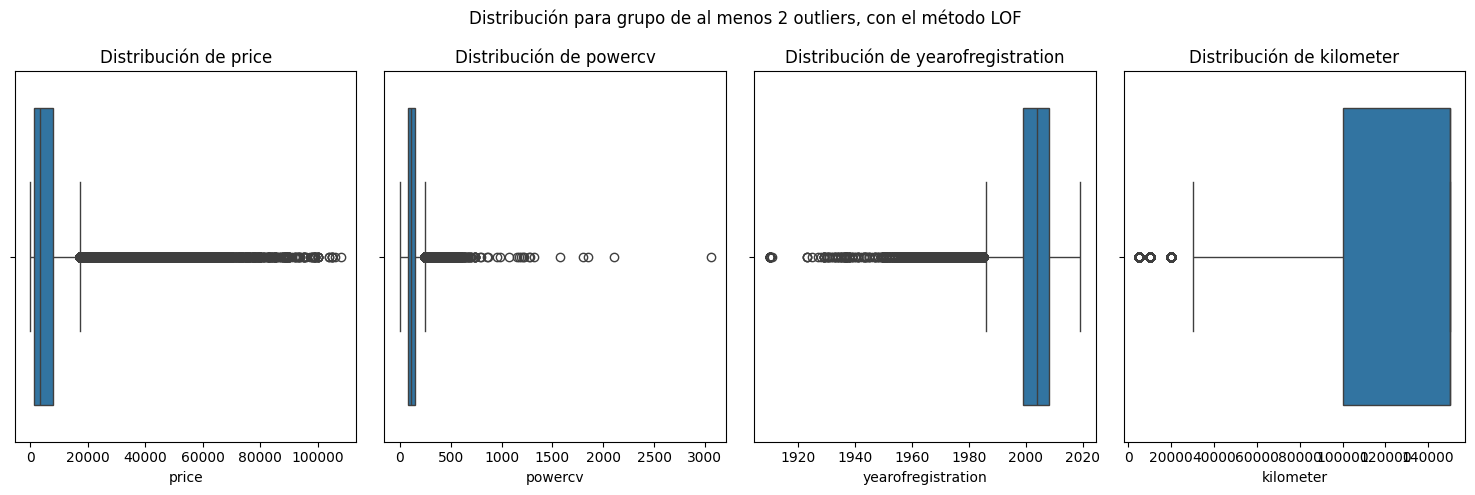

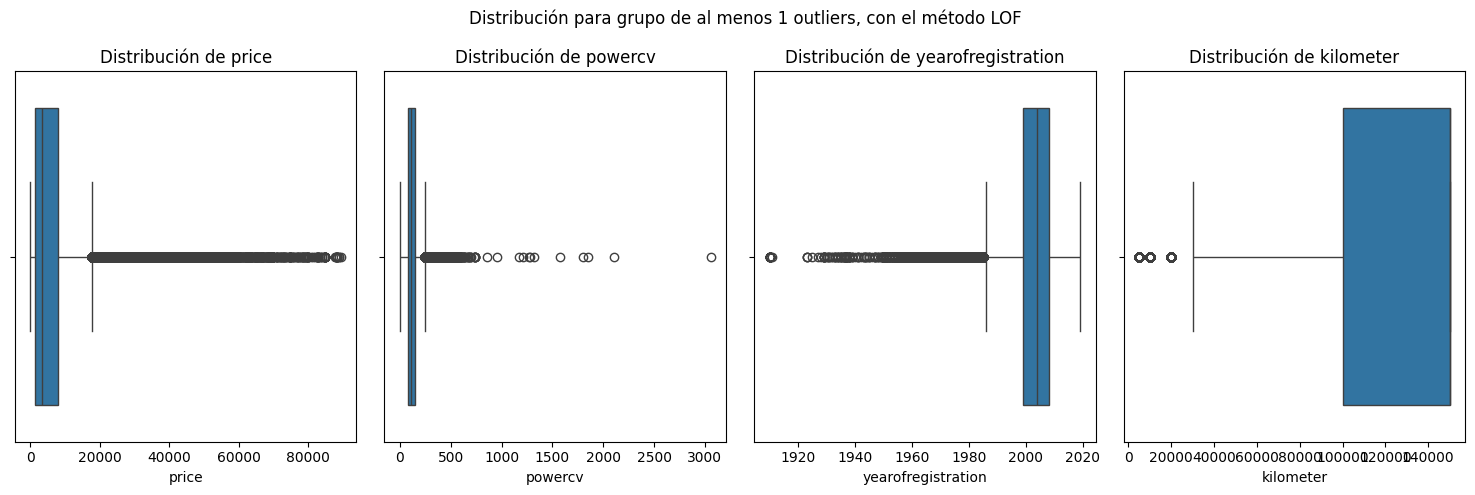

In [48]:
# LOF
for i in range(6,0,-1): # de menos retrictivo a más
    fig, axes = plt.subplots(1,4,figsize=(15,5))
    axes = axes.flat

    plt.suptitle(f"Distribución para grupo de al menos {i} outliers, con el método LOF") 

    for ax, column in zip(axes, ["price","powercv","yearofregistration", "kilometer"]):
        ax.set_title(f"Distribución de {column}")
        sns.boxplot(data=autorenew_df.query(f"outlier_{i} == 0"),
                    # bins=30,
                    x=column,
                    ax=ax)
    plt.tight_layout()
    plt.show()

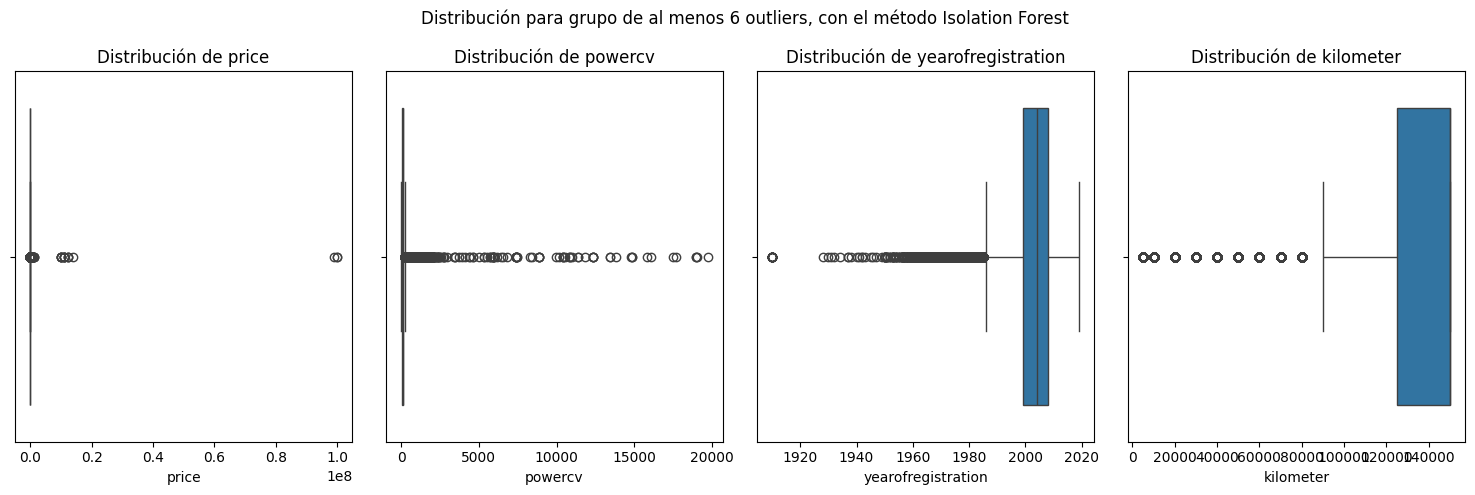

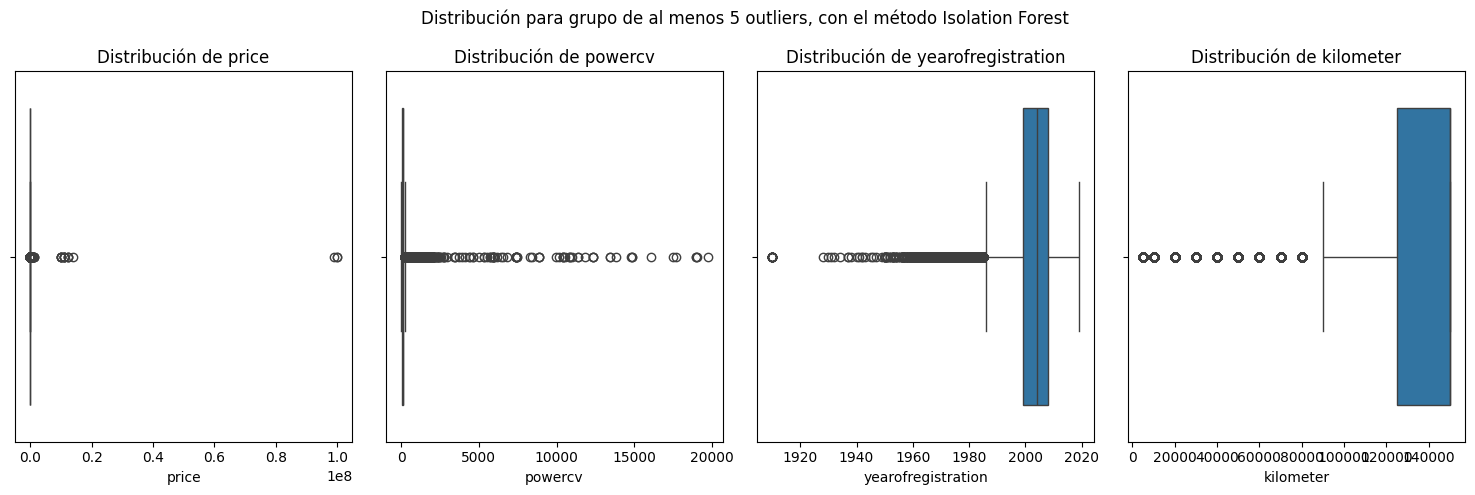

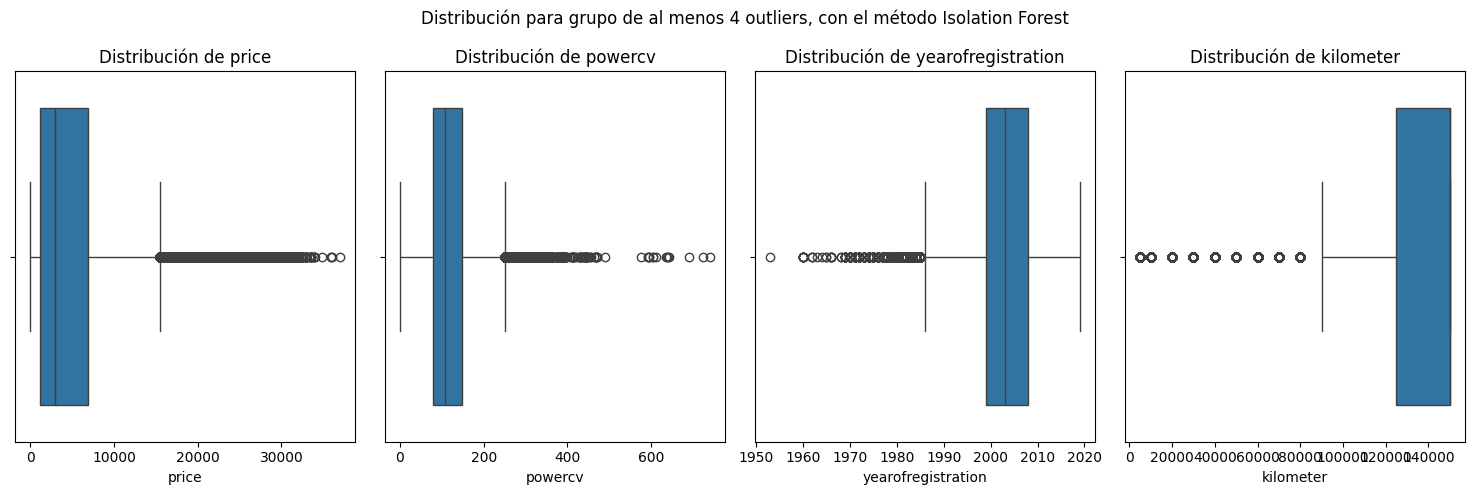

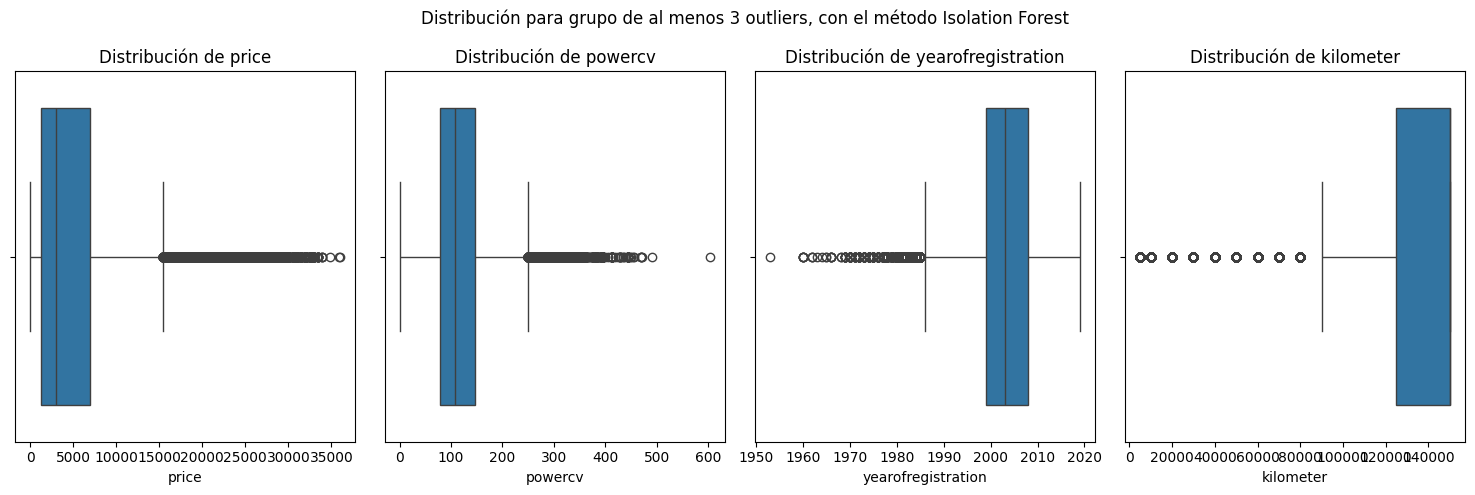

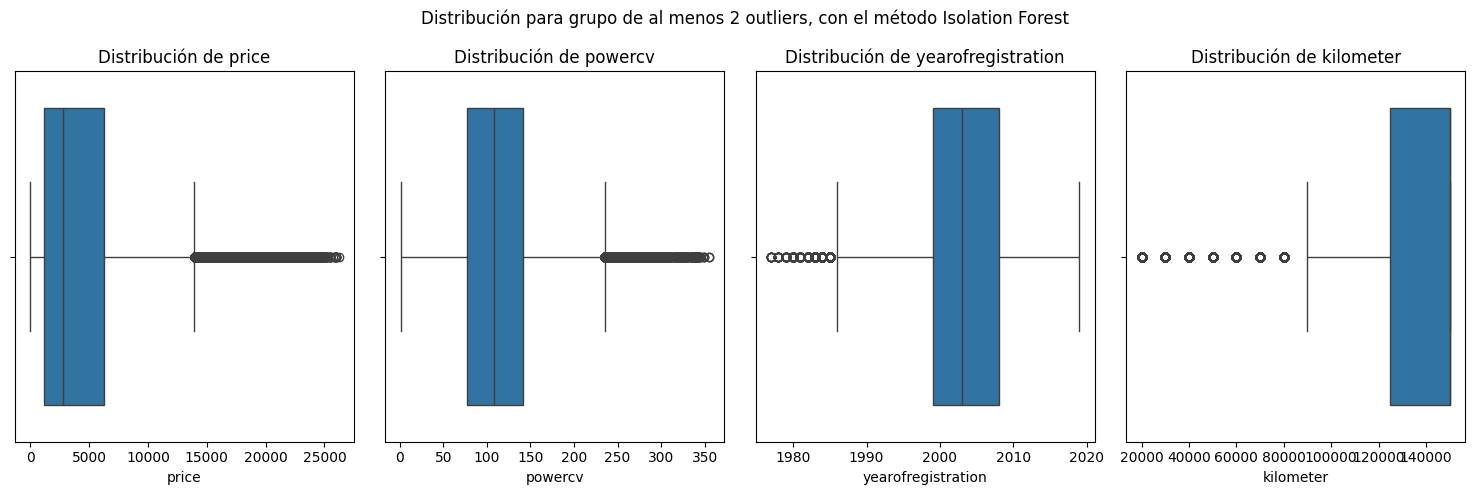

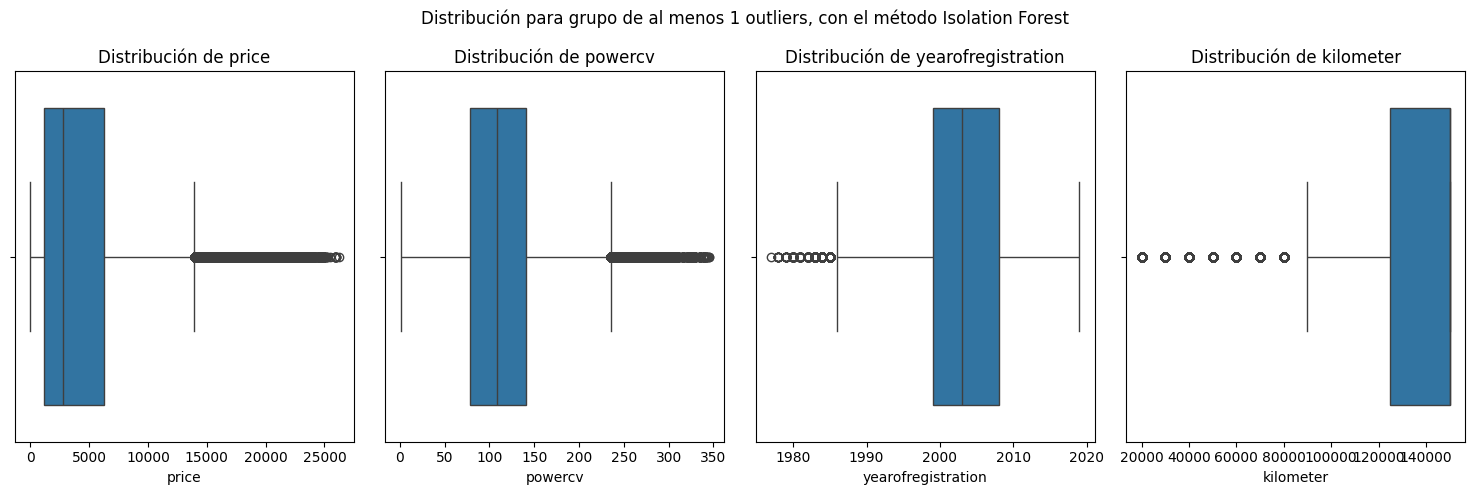

In [ ]:
# Isolation Forest
for i in range(6,0,-1): # de menos retrictivo a más
    fig, axes = plt.subplots(1,4,figsize=(15,5))
    axes = axes.flat

    plt.suptitle(f"Distribución para grupo de al menos {i} outliers, con el método Isolation Forest") 

    for ax, column in zip(axes, ["price","powercv","yearofregistration", "kilometer"]):
        ax.set_title(f"Distribución de {column}")
        sns.boxplot(data=autorenew_df.query(f"outlier_if_{i} == 0"),
                    # bins=30,
                    x=column,
                    ax=ax)
    plt.tight_layout()
    plt.show()

#### Comparando Isolation Forest, outliers 3 o más vs 1 o más

Ya que es imposible valorar la calidad lógica de la detección de outliers entre los grupos que han detectado 3 outliers vs los que han detectado 1 de forma cuantitativa, es necesario compararlos inspeccionando los valores que acompañan a los valores extremos, variable a variable, para cada uno de ambos grupos.

##### 1. Variable 'price'

In [100]:
display(autorenew_df.query("outlier_if_3 == 0").filter(regex="^(?!outlier)").sort_values("price",ascending=False).head())
autorenew_df.query("outlier_if_1 == 0").filter(regex="^(?!outlier)").sort_values("price",ascending=False).head()

,datecrawled,price,abtest,vehicletype,yearofregistration,gearbox,powercv,model,kilometer,fueltype,brand,notrepaireddamage,datecreated,lastseen,fueltype_grouped,brand_grouped,total_outlier
143676,2016-04-02 13:40:35,36000.0,test,suv,2003.0,automatic,154.0,g_klasse,150000.0,diesel,mercedes_benz,no,2016-04-02,2016-04-06 11:44:59,diesel,mercedes_benz,0
149737,2016-03-10 18:52:11,35900.0,test,suv,2005.0,automatic,154.0,g_klasse,150000.0,diesel,mercedes_benz,no,2016-03-10,2016-04-06 00:45:33,diesel,mercedes_benz,0
39997,2016-04-03 17:48:01,34900.0,test,suv,2006.0,automatic,154.0,g_klasse,150000.0,diesel,mercedes_benz,no,2016-04-03,2016-04-05 18:17:13,diesel,mercedes_benz,0
147146,2016-03-27 15:55:43,33950.0,control,bus,2010.0,automatic,177.0,transporter,150000.0,diesel,volkswagen,no,2016-03-27,2016-04-05 11:47:40,diesel,volkswagen,0
138846,2016-03-26 14:57:16,33900.0,control,bus,2008.0,manually,172.0,transporter,150000.0,diesel,volkswagen,no,2016-03-26,2016-04-06 02:46:31,diesel,volkswagen,0


,datecrawled,price,abtest,vehicletype,yearofregistration,gearbox,powercv,model,kilometer,fueltype,brand,notrepaireddamage,datecreated,lastseen,fueltype_grouped,brand_grouped,total_outlier
29395,2016-04-01 18:06:18,26200.0,control,combi,2011.0,automatic,168.0,e_klasse,80000.0,diesel,mercedes_benz,no,2016-04-01,2016-04-02 10:26:36,diesel,mercedes_benz,0
147626,2016-04-02 10:54:01,26000.0,test,bus,2007.0,manually,148.0,viano,150000.0,diesel,mercedes_benz,no,2016-04-02,2016-04-06 08:45:15,diesel,mercedes_benz,0
26348,2016-04-01 17:44:36,26000.0,test,bus,2007.0,manually,148.0,viano,150000.0,diesel,mercedes_benz,no,2016-04-01,2016-04-05 12:47:21,diesel,mercedes_benz,0
260883,2016-04-01 17:49:51,26000.0,test,bus,2007.0,manually,148.0,viano,150000.0,diesel,mercedes_benz,no,2016-04-01,2016-04-05 13:16:48,diesel,mercedes_benz,0
263033,2016-03-24 15:56:25,25990.0,test,suv,2011.0,automatic,168.0,glk,80000.0,diesel,mercedes_benz,no,2016-03-24,2016-04-07 08:45:09,diesel,mercedes_benz,0


**En el caso de 'price', detección de 3 outliers o más.**

Se observa un de 36.000 euros. Los precios en las primeras 5 filas se consideran razonables e incluso baratos para Mercedes Clase G y Volkswagen Transporter

**En el caso de 'price', detección de 1 outliers o más.**

Se observa un de 26.200 euros. Los precios encontrados también se consideran razonables.

##### 2. Variable 'powercv'

In [95]:
display(autorenew_df.query("outlier_if_3 == 0").filter(regex="^(?!outlier)").sort_values("powercv",ascending=False).head())
autorenew_df.query("outlier_if_1 == 0").filter(regex="^(?!outlier)").sort_values("powercv",ascending=False).head()

,datecrawled,price,abtest,vehicletype,yearofregistration,gearbox,powercv,model,kilometer,fueltype,brand,notrepaireddamage,datecreated,lastseen,fueltype_grouped,brand_grouped,total_outlier
4051,2016-03-15 12:25:36,3000.0,test,small car,2005.0,automatic,603.6,a3,150000.0,diesel,audi,no,2016-03-15,2016-03-15 12:25:36,diesel,audi,1
151284,2016-03-23 17:50:29,691.0,control,small car,2002.0,manually,490.4,clio,150000.0,petrol,renault,no,2016-03-23,2016-04-05 22:17:23,petrol,renault,1
307255,2016-03-14 10:45:06,360.0,control,convertible,2000.0,automatic,470.8,megane,150000.0,hybrid,renault,no,2016-03-14,2016-03-17 21:19:01,other,renault,1
290983,2016-04-06 01:36:16,5000.0,control,coupe,2006.0,automatic,469.0,e_klasse,150000.0,petrol,mercedes_benz,no,2016-04-06,2016-04-06 01:36:16,petrol,mercedes_benz,1
295348,2016-03-29 13:52:21,8990.0,control,coupe,2004.0,automatic,469.0,e_klasse,150000.0,petrol,mercedes_benz,no,2016-03-29,2016-03-29 13:52:21,petrol,mercedes_benz,1


,datecrawled,price,abtest,vehicletype,yearofregistration,gearbox,powercv,model,kilometer,fueltype,brand,notrepaireddamage,datecreated,lastseen,fueltype_grouped,brand_grouped,total_outlier
119370,2016-03-11 01:01:25,3750.0,test,suv,2002.0,automatic,345.0,c2,150000.0,lpg,bmw,yes,2016-03-11,2016-03-11 13:45:01,other,bmw,1
29577,2016-03-11 01:58:01,3750.0,test,suv,2002.0,automatic,345.0,c2,150000.0,lpg,bmw,yes,2016-03-11,2016-03-11 06:56:02,other,bmw,1
130609,2016-03-10 10:50:39,5950.0,test,suv,2003.0,automatic,344.0,impreza,150000.0,lpg,sonstige_autos,no,2016-03-10,2016-03-11 10:18:26,other,other,0
104777,2016-03-21 17:25:24,5490.0,control,coupe,2002.0,automatic,343.0,cl,150000.0,petrol,mercedes_benz,no,2016-03-21,2016-04-05 15:18:18,petrol,mercedes_benz,1
165548,2016-04-01 19:56:01,4999.0,control,convertible,2002.0,automatic,342.0,x_reihe,150000.0,lpg,bmw,no,2016-04-01,2016-04-05 16:45:47,other,bmw,1


**En el caso de 'powercv', detección de 3 outliers o más.**

Se aprecia que el máximo  es de 603CV. Esta potencia es correspondiente con coches deportivos de alto lujo, que dificilmente se corresponde con 3mil euros, por mucho que el vehículo cuente con 150mil km recorridos y con un coche marca Audi modelo A3. Lo mismo con los siguientes, que serían un Renaul Clio y un Megane.

**En el caso de 'powercv', detección de 1 outliers o más.**

Se aprecia que el máximo  es de 345CV. Esta potencia también se suele dar en coches de lujo, pero ya entra dentro de un rango más "razonable" y le corresponde a un coche de marca BMW C2, que sí que es un vehículo deportivo. Si bien el precio puede considerarse bajo para un coche deportivo aunque su kilometraje sea alto, este valor puede deberse a efectos de diversos factores como demanda local, por ejemplo, y es una mejoría con respecto al grupo anterior. Sin embargo, se aprecian otras irregularidades como que se considere que un coche deportivo como es un c2 sea tipo SUV, pero eso es una cuestión a evaluar de forma separada a los outliers de 'powercv'.

##### 3. Variable 'yearofregistration'

In [98]:
display(autorenew_df.query("outlier_if_3 == 0").filter(regex="^(?!outlier)").sort_values("yearofregistration").head())
autorenew_df.query("outlier_if_1 == 0").filter(regex="^(?!outlier)").sort_values("yearofregistration").head()

,datecrawled,price,abtest,vehicletype,yearofregistration,gearbox,powercv,model,kilometer,fueltype,brand,notrepaireddamage,datecreated,lastseen,fueltype_grouped,brand_grouped,total_outlier
254179,2016-03-17 17:45:47,1499.0,control,convertible,1953.0,automatic,115.4,andere,150000.0,hybrid,opel,yes,2016-03-17,2016-03-28 21:17:15,other,opel,1
278076,2016-03-10 12:57:52,1500.0,test,coupe,1960.0,manually,89.0,golf,150000.0,petrol,volkswagen,no,2016-03-10,2016-04-07 08:15:40,petrol,volkswagen,1
124081,2016-03-26 09:52:09,2200.0,control,coupe,1960.0,automatic,104.0,andere,150000.0,petrol,mazda,no,2016-03-26,2016-04-05 21:17:35,petrol,mazda,1
279430,2016-03-30 22:54:29,1000.0,control,convertible,1960.0,automatic,125.7,impreza,150000.0,hybrid,sonstige_autos,no,2016-03-30,2016-04-05 19:15:31,other,other,1
272133,2016-03-10 18:45:55,540.0,test,convertible,1960.0,manually,74.0,lupo,150000.0,hybrid,volkswagen,yes,2016-03-10,2016-03-20 06:18:13,other,volkswagen,1


,datecrawled,price,abtest,vehicletype,yearofregistration,gearbox,powercv,model,kilometer,fueltype,brand,notrepaireddamage,datecreated,lastseen,fueltype_grouped,brand_grouped,total_outlier
36903,2016-03-09 19:45:07,750.0,test,convertible,1977.0,manually,94.7,andere,150000.0,diesel,lada,no,2016-03-09,2016-03-12 05:46:40,diesel,other,0
69397,2016-03-10 20:53:20,850.0,test,combi,1978.0,manually,71.0,a4,150000.0,petrol,audi,no,2016-03-10,2016-04-06 09:17:38,petrol,audi,0
253461,2016-03-07 13:56:48,1500.0,control,convertible,1978.0,manually,89.0,3er,150000.0,petrol,bmw,yes,2016-03-07,2016-04-06 12:44:49,petrol,bmw,1
63630,2016-03-19 19:55:00,1800.0,control,coupe,1978.0,manually,101.2,kadett,150000.0,petrol,opel,no,2016-03-19,2016-03-19 20:43:03,petrol,opel,0
357966,2016-03-25 17:52:07,1200.0,test,bus,1978.0,automatic,79.0,gl,150000.0,petrol,sonstige_autos,no,2016-03-25,2016-03-25 17:52:07,petrol,other,0


**En el caso de 'yearofregistration', detección de 3 outliers o más.**

El mínimo es el año 1953. En los primeros valores se ven muchos coches híbridos, cosa que carece de sentido en aquella época. Los precios además, sin ser altos per se, lo son teniendo en cuenta el año de fabricación a no ser que se les pueda considerar clásicos.

**En el caso de 'yearofregistration', detección de 1 outliers o más.**

El mínimo es el año 1977. En este caso los tipos de combustible tienen más sentido. Los precios son parecidos, pero algo más aceptables dada la diferencia de 20 años.

##### 4. Variable 'kilometer'

In [99]:
display(autorenew_df.query("outlier_if_3 == 0").filter(regex="^(?!outlier)").sort_values("kilometer").head())
autorenew_df.query("outlier_if_1 == 0").filter(regex="^(?!outlier)").sort_values("kilometer").head()

,datecrawled,price,abtest,vehicletype,yearofregistration,gearbox,powercv,model,kilometer,fueltype,brand,notrepaireddamage,datecreated,lastseen,fueltype_grouped,brand_grouped,total_outlier
309753,2016-03-19 21:52:13,6450.0,control,combi,2005.0,automatic,125.0,andere,5000.0,diesel,fiat,no,2016-03-19,2016-04-07 11:16:43,diesel,fiat,0
56166,2016-03-08 15:38:37,20.0,test,convertible,2005.0,automatic,103.9,bravo,5000.0,hybrid,bmw,no,2016-03-08,2016-04-06 06:46:35,other,bmw,0
300460,2016-04-02 19:39:53,190.0,control,combi,2002.0,manually,94.0,i_reihe,5000.0,hybrid,renault,yes,2016-04-02,2016-04-02 19:39:53,other,renault,0
140470,2016-03-08 19:56:09,14800.0,test,bus,2015.0,manually,108.0,c3,5000.0,petrol,citroen,no,2016-03-08,2016-04-05 15:47:19,petrol,citroen,0
99812,2016-03-11 10:40:41,10.0,test,convertible,2000.0,automatic,100.2,zafira,5000.0,hybrid,opel,no,2016-03-11,2016-03-20 16:45:05,other,opel,0


,datecrawled,price,abtest,vehicletype,yearofregistration,gearbox,powercv,model,kilometer,fueltype,brand,notrepaireddamage,datecreated,lastseen,fueltype_grouped,brand_grouped,total_outlier
208681,2016-03-28 15:54:02,9990.0,control,bus,2012.0,automatic,138.0,andere,20000.0,petrol,kia,no,2016-03-28,2016-03-28 15:54:02,petrol,other,0
259026,2016-03-30 18:49:17,8990.0,test,small car,2009.0,manually,153.0,andere,20000.0,petrol,alfa_romeo,no,2016-03-30,2016-04-07 10:16:54,petrol,other,0
324881,2016-03-09 13:49:33,5250.0,control,small car,2009.0,manually,64.0,punto,20000.0,petrol,fiat,no,2016-03-09,2016-03-11 08:44:29,petrol,fiat,0
324813,2016-03-14 21:48:33,13000.0,test,small car,2010.0,automatic,120.0,a1,20000.0,petrol,audi,no,2016-03-14,2016-03-22 20:18:31,petrol,audi,0
143179,2016-03-15 20:53:34,14500.0,test,combi,2012.0,manually,120.0,octavia,20000.0,petrol,skoda,no,2016-03-15,2016-03-30 13:16:15,petrol,skoda,0


**En el caso de 'yearofregistration', detección de 3 outliers o más.**

El mínimo son 5000km. Resalta la aparición de coches de los años 2000, 2002 y 2005, años que se antojan poco probables dado el bajo kilometraje. Esto se vuelve escandaloso teniendo en cuenta precios de 10, 20 y 190 euros.

**En el caso de 'yearofregistration', detección de 1 outliers o más.**

El mínimo son 20000km. En este caso los años parecen subir y esta subida viene acompañada de subida en los precios, que tiene sentido dado el bajo kilometraje de los coches. Se observan precios incluso demasiado altos como los del Skoda octavia en la quinta fila.

In [90]:
price_min = autorenew_df.query("outlier_if_3 == 0").filter(regex="^(?!outlier)")["price"].min()
autorenew_df.query("outlier_if_3 == 0").filter(regex="^(?!outlier)")[autorenew_df["price"]==price_min].head()

,datecrawled,price,abtest,vehicletype,yearofregistration,gearbox,powercv,model,kilometer,fueltype,brand,notrepaireddamage,datecreated,lastseen,fueltype_grouped,brand_grouped,total_outlier
58,2016-03-29 15:48:15,1.0,control,suv,1994.0,manually,282.0,jazz,150000.0,hybrid,sonstige_autos,no,2016-03-29,2016-04-06 01:44:38,other,other,1
89,2016-03-28 09:37:01,1.0,control,combi,1995.0,manually,111.0,e_klasse,150000.0,diesel,mercedes_benz,no,2016-03-28,2016-04-06 12:15:54,diesel,mercedes_benz,0
272,2016-03-12 07:26:49,1.0,test,coupe,1990.0,manually,89.0,80,70000.0,petrol,audi,no,2016-03-11,2016-03-26 23:15:49,petrol,audi,0
414,2016-03-29 18:51:58,1.0,control,coupe,2000.0,automatic,74.0,golf,90000.0,petrol,volkswagen,no,2016-03-29,2016-04-06 04:45:50,petrol,volkswagen,0
917,2016-03-06 00:25:25,1.0,control,convertible,1990.0,manually,142.6,andere,150000.0,hybrid,porsche,no,2016-03-05,2016-04-06 20:19:08,other,other,0
